In [1]:
plate_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1.csv"
plate_1_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1_repeat.csv"
plate_2_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_1.csv"
plate_2_2 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_2.csv"
plate_2_3 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_3.csv"
plate_2_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat.csv"
plate_2_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat _96.csv"
list_A = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA.csv"
list_A_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA_repeat.csv"
list_B = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB.csv"
list_B_repeat_end = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _end.csv"
list_B_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _96.csv"
list_C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listC.csv"

HsHis6_PEX5C_vs_HsPEX5C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT.csv"
F606C_vs_AtPEX5C_WT_1_hour = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour.csv"

plate_map_file = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate_map.csv"
Hs_His6_PEX5C_vs_HsPEX5C_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C platemap.csv"
Hs_His6_PEX5C_vs_HsPEX5C_tracer_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C tracer platemap.csv"
Hs_His6_PEX5C_vs_HsPEX5C_competitor_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\Hs-His6-PEX5C vs HsPEX5C competitor platemap.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\HsPEX5C Y467C vs AtPEX5C WT platemap.csv"
F606C_vs_AtPEX5C_WT_1_hour_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\F606C vs AtPEX5C WT 1 hour platemap.csv"

AURKA_NMYC = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\AURKA NMYC.csv"
AURKA_NMYC_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\AURKA NMYC_platemap.csv"
AURKA_NMYC_comp = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\AURKA NMYC_comp.csv"
AURKA_NMYC_comp_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\real data\\AURKA NMYC_comp_platemap.csv"

In [2]:
import csv
import re
import string
import math
import warnings
import pandas as pd
import numpy as np
import ipywidgets as wg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from itertools import product
from scipy.optimize import curve_fit
from plate_mapping import plate_mapping as pm

# define custom errors
class DataError(Exception):
    pass

class PlateSizeError(Exception):
    pass

class DataTypeError(Exception):
    pass

# define well plate dimensions
plate_dim = {96:(8, 12), 384:(16, 24)}

# define header names for platemapping module
pm.header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Contents': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                }

class FA:
    """Class used for the analysis of fluorescence anisotropy data.
    
    :param data_dict: A dictionary contaning data frames with pre-processed data and metadata
    :type data_dict: dict
    :param g_factor: G-factor
    :type g_factor: float 
    :param plate_map: dataframe from a plate map csv file that defines each and every well
    :type plate_map: pandas df"""
    
    def __init__(self, data_dict, g_factor, plate_map):
        self.data_dict = data_dict
        self.g_factor = g_factor
        self.plate_map = plate_map
       
        # create list of all p and s data frames to run some stats
        frames = []   
        for repeat in self.data_dict.values():   
            metadata, data = repeat.values()
            p_channel, s_channel = data.values()
            frames.append(p_channel)
            frames.append(s_channel)
    
        new = pd.concat(frames, axis=1)   # join all p and s data frames into one df
        nan = new.size - new.describe().loc['count'].sum()   # find number of 'nan' cells
        
        # create a data frame to store the final fitting parameters
        p_names = self.plate_map['Protein Name'].dropna().unique()   # get all protein names
        t_names = self.plate_map['Tracer Name'].dropna().unique()   # get all trcaer names 
        c_names = self.plate_map['Competitor Name'].dropna().unique()   # get all competitor names
        if len(c_names) == 0:   # if there is no comeptitor, replace nan with a string
            c_names = ['-']
        
        FA.final_fit = pd.DataFrame(index=pd.MultiIndex.from_product([p_names, t_names, c_names]), 
            columns=['rmin', 'rmin error', 'rmax', 'rmax error', 'lambda', 'Kd', 'Kd error'])  
        FA.final_fit["lambda"] = 1   # set the default lambda value as 1
        #FA.final_fit = final_fit   # add the final_fit df as a class vriable
            
        print("Data has been uploaded!\n")
        print(f"Number of repeats: {len(self.data_dict)} \nValue of g-factor: {self.g_factor} \nOverall number of empty cells is {int(nan)} in {len(frames)} data frames.\nProteins: {p_names}\nTracers: {t_names}\nCompetitors: {c_names}")
              
              
    @classmethod
    def read_in_envision(cls, data_csv, platemap_csv, data_type='plate', size=384):
        """Reads in the raw data from csv file along with a platemap and constructs the FA class boject.
        
        :param data_csv: File path of the raw data file in .csv format.
        :type data_csv: str
        :param platemap_csv: File path of the platemap file in .csv format.
        :type platemap_csv: str
        :param data_type: Format in which the raw data was exported (plate or list), defaults to plate.
        :type data_type: str
        :param size: Size of the well plate (384 or 96), defaults to 384.
        :type size: int
        :return: A dictionary contaning data frames with pre-processed data, g-factor, data frame containing platemap.
        :rtype: dict, float, pandas df """
        
        # ensure the plate size is either 384 or 96
        if size not in plate_dim:
            raise PlateSizeError('Invalid size of the well plate, should be 384 or 96.')
        
        # try to read in data in plate format
        if data_type == 'plate':
            try:
                data_dict, g_factor = FA._read_in_plate(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError, ValueError):
                raise DataError(f"Error occured during data read in. Check your file contains data in the 'plate' format and plate size is {size}.")
        
        # try to read in data in list format
        if data_type == 'list':
            try:
                data_dict, g_factor = FA._read_in_list(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError):
                raise DataError("Error occured during data read in. Check your file contains data in the 'list' format.")
        
        else:
            raise DataTypeError(f"'{data_type}' is not one of the two valid data types: plate or list.")
    

    def _read_in_plate(csv_file, size):
        """Reads the raw data file and finds the information needed to extract data. Passes those parameters to pre_process_plate function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor 
        :rtype: tuple """
        
        with open(csv_file) as file:
            all_data_lines = list(csv.reader(file, delimiter=','))   # read the csv file and cast it into a list containing all lines

        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [])   # list containing indices of all blank rows
        if blank_indexes == []:
            blank_indexes = list(index for index, item in enumerate(all_data_lines) if set(item) == {''})
        blanks = np.array(blank_indexes)   # convert the list of blank indices to a numpy array
        read_in_info = []   # list to store the tuples with parameters needed for pandas to read in the csv file

        for index, item in enumerate(all_data_lines):   # iterate over all lines in the csv file
            
            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) == None and re.findall(r"Formula", all_data_lines[index+1][10]) != ['Formula']:
                skiprows = index + 9   # Set the skiprows parameter for raw data table
                skiprows_meta = index + 1   # Set the skiprows parameter for metadata table
                end_of_data = blanks[blanks > skiprows].min()   # Calculate the end of data table by finding the smallest blank index after the beginning of data table
                read_in_info.append((skiprows, end_of_data - skiprows + 1, skiprows_meta))   # add the skiprows, caculated number of data lines and skiprows for metadata parameters to the list as a tuple
                data_format = 'plate1'

            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) != None:
                skiprows = index + 10
                skiprows_meta = index + 1
                end_of_data = blanks[blanks > skiprows].min()
                read_in_info.append((skiprows, end_of_data - skiprows - 1, skiprows_meta))
                data_format = 'plate2'

            if item != [] and len(item) > 1 and re.fullmatch(r"G-factor", item[0]):
                g_factor = float(item[4])   
        
        return FA._pre_process_plate(csv_file, read_in_info, data_format, size), g_factor

    def _pre_process_plate(csv_file, read_in_info, data_format, size):    
        """Extracts the data and metadata from the csv file, processes it and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param read_in_info: Tuples with read in parameters for each channel.
        :type read_in_info: list
        :param data_format: Plate type (plate1 or plate2)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata 
        :rtype: dict """ 
        
        data_frames = {}   # dictionary to store data frames
        counter = 1   # counter incremented by 0.5 to enable alternating labelling of data frames as 'p' or 's'

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, item in enumerate(read_in_info):   # iterate over all tuples in the list, each tuple contains skiprows, nrows and skiprows_meta for one channel 

            if data_format == 'plate1':   # raw data table does not have row and column names so 'names' parameter passed to omit the last column
                raw_data = pd.read_csv(csv_file, sep=',', names=col_numbers, index_col=False, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')

            if data_format == 'plate2':   # raw data table has row and column names, so index_col=0 to set the first column as row labels
                raw_data = pd.read_csv(csv_file, sep=',', index_col=0, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')
                if len(raw_data.columns) in [13, 25]:    
                    raw_data.drop(raw_data.columns[-1], axis=1, inplace=True)    # delete the last column because it is empty

            # generate df for metadata (number of rows of metadata table is always 1) and convert measurement time into datetime object   
            metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=item[2], nrows=1, encoding='utf-8').astype({'Measurement date': 'datetime64[ns]'})
            
            # convert and reshape data frame into 1D array
            data_as_array = np.reshape(raw_data.to_numpy(), (int(size), 1)) 

            if counter % 1 == 0: 
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['p'])   # generate new 384 (or 96) by 1 data frame with p channel data
                data_frames[f'repeat_{int(counter)}'] = {'metadata':metadata, 'data': {'p': new_data, 's':''}}   # add p channel data and metadata dfs to dictionary

            if counter % 1 != 0:
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['s'])   # generate new 384 (or 96) by 1 data frame with s channel data
                data_frames[f'repeat_{int(counter-0.5)}']['data']['s'] = new_data   # add s channel data to dictionary

            counter = counter + 0.5
        
        return data_frames


    def _read_in_list(csv_file, size):
        """Reads the raw data file and extracts the data and metadata. Passes the raw data to pre_process_list function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor
        :rtype: tuple """

        with open(csv_file) as file:  
            all_data_lines = list(csv.reader(file, delimiter=',')) # read the csv file and cast it into a list containing all lines
 
        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [] or set(item) == {''})   # list containing indexes of all blank rows
        blanks = np.array(blank_indexes)   # convert the list of blank indexes to a numpy array
        
        # iterate over all lines to find beggining of the data table ('skiprows') and determine the format of data  (list A, B, or C)
        for index, item in enumerate(all_data_lines):   
            if item != [] and len(item) == 1 and re.findall(r"Plate information", item[0]) == ["Plate information"]:
                skiprows_meta = index + 1
                end_of_metadata = blanks[blanks > skiprows_meta].min()   # find the end of metadata by finding the smallest blank index after the beginning of metadata
                
            if item != [] and len(item) >= 2 and re.findall(r"PlateNumber", item[0]) == ['PlateNumber'] and re.findall(r"PlateRepeat", item[1]) == ['PlateRepeat']:   # find line number with the beggining of the data
                skiprows = index - 1
                data_format = 'listA'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate'] and re.findall(r"Barcode", item[1]) == ['Barcode']:   # find line number with the beggining of the data
                skiprows = index
                data_format = 'listB'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate']  and re.findall(r"Well", item[1]) == ['Well']:
                skiprows = index
                data_format = 'listC'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and re.fullmatch(r"G-factor", item[0]):   # find the g factor
                g_factor = float(item[4])

        nrows = end_of_data - skiprows - 1   # calculate the length of data table
        nrows_meta = end_of_metadata - skiprows_meta - 1   # calucalte the length of metadata table (number of rows depends on the number of repeats)

        raw_data = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows, nrows=nrows, encoding='utf-8')
        raw_metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows_meta, nrows=nrows_meta, encoding='utf-8')

        return FA._pre_process_list(raw_data, raw_metadata, data_format, size), g_factor

    def _pre_process_list(raw_data, raw_metadata, data_format, size):
        """Extracts the data and metadata for each channel and repeat from the raw data and raw metadata 
        and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param raw_data: Data frame containing raw data
        :type raw_data: pandas data frame
        :param raw_metadata: Data frame containing raw metadata
        :type raw_metadata: pandas data frame
        :param data_format: Type of list (listA, listB, or listC)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata
        :rtype: dict"""

        # remove the '0' from middle position of well numbers (A01 -> A1), done by reassigning the 'Well' column to a Series containing modified well numbers
        raw_data['Well'] = raw_data['Well'].apply(lambda x: x[0] + x[2] if x[1] == '0' else x)
        
        data_frames = {}   # dictionary to store data frames
        repeats = list(raw_metadata['Repeat'].to_numpy())   # generate a list with repeats based on the metadata table, e.g. for 3 repeats -> [1,2,3]

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, repeat in enumerate(repeats):   # iterate over the number of repeats
            
            if data_format == 'listA':
                
                groupped_data = raw_data.groupby(raw_data.PlateRepeat).get_group(repeat)   # group and extract the data by the plate repeat column, i.e. in each iteration get data only for the current repeat 

                p_groupped = groupped_data.iloc[::3, :]   # extract data only for the p channel, i.e. each third row starting from the first row
                s_groupped = groupped_data.iloc[1::3, :]   # extract data only for the s channel, i.e. each third row starting from the second row
                p_raw_data = p_groupped[['Well', 'Signal']]   # extract only the two relevant columns
                s_raw_data = s_groupped[['Well', 'Signal']]   # for each channel

            if data_format in ['listB', 'listC']: 
                
                # the column naming is different for the first repeat ('Signal'), then it's 'Signal.1', 'Signal.2', etc.
                if repeat == 1: 
                    p_raw_data = raw_data[['Well', 'Signal']]   
                    s_raw_data = raw_data[['Well', f'Signal.{repeat}']]
                else:
                    p_raw_data = raw_data[['Well', f'Signal.{repeat + index - 1}']]   # the column cotntaining data to be extracted is calculated in each iteration
                    s_raw_data = raw_data[['Well', f'Signal.{repeat + index}']]
            
            # create an empty df with no columns and indexes matching the plate size
            indexes = pd.DataFrame(well_ids, columns=['Wells'])
            empty_frame = indexes.set_index('Wells')
            
            p_raw_data.set_index('Well', inplace=True)   # set the row indexes as the well numbers
            p_raw_data.set_axis(['p'], axis=1, inplace=True)   # rename the 'Signal' column to 'p'
            p_data = empty_frame.join(p_raw_data)   # join the raw data df to an empty frame based on the indexes, assigns 'NaN' to indexes not present in the raw data table
            
            s_raw_data.set_index('Well', inplace=True) 
            s_raw_data.set_axis(['s'], axis=1, inplace=True)
            s_data = empty_frame.join(s_raw_data)
    
            metadata = raw_metadata.iloc[[repeat-1]].astype({'Measurement date': 'datetime64[ns]'})   # extract the row with metadata relevant for each repeat and covert date and time into a datetime object
            data_frames[f'repeat_{repeat}'] = {'metadata': metadata, 'data': {'p': p_data, 's': s_data}}   # add data frames to the dictionary

        return data_frames
    
    
    def visualise(self, colorby='Type', labelby='Type', title="", cmap='rainbow', dpi=250, export=False):
        """Returns a visual representation of the plate map.
        
        The label and colour for each well can be customised to be a platemap variable, for example 'Type', 'Protein Name', 'Protein Concentration', etc.
        It can also be the p or s channel value, calculated anisotropy or intensity, however in such cases the 'colorby' or 'labelby'
        parameters must be passed as tuple of two strings specifying the repeat number and variable to display, for example ('repeat_2', 'p_corrected').
        
        :param colorby: Variable to color code by, for example 'Type', 'Contents', 'Protein Concentration', ('repeat_2', 'p'), defaults to 'Type'.
        :type colorby: str or tuple
        :param labelby: Variable to display on the wells, for example 'Type', 'Protein Name', ('repeat_1', 's_corrected'), defaults to 'Type'.
        :type labelby: str or tuple
        :param title: Sets the title of the figure, defaults to None.
        :type title: str
        :param cmap: Sets the colormap for the color-coding, defaults to 'Paired'.
        :type cmap: str
        :param dpi: Resolution of the exported figure in points per inches, defaults to 250.
        :type dpi: int
        :param export: If True, save the figure as .png file, defaults to False.
        :type export: bool
        :return: Visual representation of the plate map.
        :rtype: figure
        """
        plate_map = self.plate_map
        size = plate_map.shape[0]
        str_format = None
        str_len = None
        
        if type(labelby) == tuple:   # option for labelling by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[labelby[0]]['data'][labelby[1]])   # data frame containing p or s values from specified repeat is added to the platemap
            labelby = labelby[1]
            if labelby == 'i_percent':
                str_format = 'percent'
                str_len = 3

        if type(colorby) == tuple:   # option for colouring by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[colorby[0]]['data'][colorby[1]])
            colorby = colorby[1]
            
        if labelby in ['Protein Concentration', 'Tracer Concentration', 'Competitor Concentration', 'p', 's', 'p_corrected', 's_corrected', 'r_raw', 'r_corrected', 'i_raw']:
            if sum((plate_map[labelby] > 1000) | (plate_map[labelby] < 0)) > 0:   # display in sci notation if the number is greater than 1000 or less than 0
                str_format = 'scinot'
                str_len = 8
        if labelby == 'i_percent':
            str_format = 'percent'
            str_len = 3
        
        return pm.visualise(platemap=plate_map, title=title, size=size, export=export, cmap=cmap, colorby=colorby, labelby=labelby, dpi=dpi, str_format=str_format, str_len=str_len)
    
    def invalidate(self, valid=False, **kwargs):
        """Invalidates wells, entire columns and/or rows. Any of the following keyword arguments, or their combination, 
        can be passed: wells, rows, columns. For example, to invalidate well A1, rows C and D and columns 7 and 8 execute  
        the following: invalidate(wells='A1', rows=['C','D'], columns=[7,8]).
        To validate previously invalidated wells, rows and/or columns, pass the additional 'valid' argument as True.
    
        :param valid: Sets the stipulated well, row or column invalid ('False') or valid ('True'), defaults to False.
        :type valid: bool
        :param wells: Wells to be invalidated passed as a string or list of strings.
        :type wells: str or list
        :param rows: Rows to be invalidated passed as a string or list of strings.
        :type rows: str or list
        :param columns: Columns to be invalidated passed as an integer or list of integers.
        :type columns: int or list
        """
        # execute the corresponding invalidate functon from the platemapping package
        if 'wells' in kwargs:
            pm.invalidate_wells(platemap=self.plate_map, wells=kwargs['wells'], valid=valid)
        
        if 'rows' in kwargs:
            rows = tuple(kwargs['rows']) # convert the rows to tuple because invalidate_rows cannot take in a list
            pm.invalidate_rows(platemap=self.plate_map, rows=rows, valid=valid)
        
        if 'columns' in kwargs:
            pm.invalidate_cols(platemap=self.plate_map, cols=kwargs['columns'], valid=valid)
        
        if len(kwargs) == 0:   # return error if neither of the keyword arguments is passed
            raise TypeError('No arguments were passed. Specify the wells, rows and/or columns to be invalidated!')
      
    
    def background_correct(self):
        """Calculates background corrected values for p and s channel in all repeats.
        
        The backgorund correction is done by subtracting the mean value of blank p (or s) channel intensity for a given 
        protein (or tracer) concentration from each non-blank value of the p (or s) channel intensity for that concentration. 
        """
        if len(self.plate_map['Tracer Concentration'].dropna().unique()) == 1:   # protein is titrated to a constant amount of tracer
            t_type = 'Protein'
        if len(self.plate_map['Protein Concentration'].dropna().unique()) == 1:   # tracer is titrated to a constant amount of protein
            t_type = 'Tracer'
        
        for key, value in self.data_dict.items(): 
            metadata, data = value.values()   
        
            # calculate p and s corrected data frame using _background_correct func and add it to data dictionary
            self.data_dict[key]['data']['p_corrected'] = FA._background_correct(data['p'], self.plate_map)
            self.data_dict[key]['data']['s_corrected'] = FA._background_correct(data['s'], self.plate_map)
            
        print('Background correction has been successfully performed!')
            
    def _background_correct(data, platemap):
        """Calculate background corrected p or s channel values for protein or tracer titration.
        
        :param data: Data frame with raw p or s channel values 
        :type data: pandas df
        :param platemap: Data frame with platemap
        :type platemap: pandas df
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :return: Data frame with background corrected values
        :rtype: pandas df
        """
        df = platemap.join(data)   # join p or s channel data to platemap
        df[df.columns[-1]] = df[df.columns[-1]][df['Valid'] == True]   # replace 'p' or 's' values with NaN if the well is invalidated
        col_name = df.columns[-1] + '_corrected'  
        no_index = df.reset_index()   # move the 'well id' index to df column
        
        # create a multindex df to which blank df will be joined
        mindex = pd.MultiIndex.from_frame(no_index[['Type','Protein Name','Protein Concentration','Tracer Name','Tracer Concentration','Competitor Name','Competitor Concentration']])   # create multiindex
        reindexed = no_index.set_index(mindex).drop(['Type','Protein Name','Protein Concentration','Tracer Name','Tracer Concentration','Competitor Name','Competitor Concentration'], axis=1)   # add multiindex to df and drop the columns from which multiindex was created
    
        mean = no_index.groupby(['Type','Protein Name','Protein Concentration','Tracer Name','Tracer Concentration','Competitor Name','Competitor Concentration'], dropna=False).mean().drop('Valid', axis=1).drop('empty', axis=0)   # calculate mean for each group of three wells and remove 'Valid' column
        mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)   # rename the last column to 'Mean' to avoid errors during joining
        blank = mean.xs('blank', level=0, drop_level=True)   # take a group with only blank wells
        
        reset_idx =  blank.reset_index()   # move multiindex to df
        nans = [col for col in reset_idx.columns if reset_idx[col].dropna().empty]    # list of all columns containing only 'nan' values
        d = reset_idx.drop(labels=nans, axis=1)   # delete all columns containing only 'nan' values
        blank2 = d.set_index(pd.MultiIndex.from_frame(d.loc[:,d.columns[:-1]])).drop(d.columns[:-1], axis=1)   # multi index to the remaining columns

        joined = reindexed.join(blank2, on=list(blank2.index.names))   # join the blank mean data on the indexes only from blank df
        joined[col_name] = joined[joined.columns[-2]] - joined[joined.columns[-1]]   # calculate background corrected values
        jindexed = joined.set_index('index', append=True).reset_index(level=[0,1,2,3,4,5,6]).rename_axis(None)   # set index to 'well id' and move multiindex to df columns
        
        return jindexed[[col_name]]   # extract and return df with corrected values

    
    def calc_r_i(self, correct=True, plot_i=True, thr=80):
        """Calculates anisotropy and fluorescence intensity for each well in all repeats using the raw and background corrected p and s channel data.
        
        The fluorescence intensity (I) and anisotropy (r) are calculated using the follwing formulas: I = s + (2*g*p) for intensity and
        r = (s - (g*p)) / I for anisotropy. Results are stored in the following data frames: i_raw and r_raw (calculated using the uncorrected 
        p and s channel values) and i_corrected and r_corrected (calculated using the background corrected p and s channel values).
        
        The function also calculates the percentage intesity of the non blank wells as comapred to the blank corrected wells using the formula:
        (raw intensity - corrected intensity) / raw intensity * 100%. If 'plot_i=True', the graph of percentage intenstiy against the 
        well ids for all repeats is displayed along with a summary of wells above the threshold (defaults to 80%).
        
        :param correct: Calculate the anisotropy and intensity using the background corrected values of p and s channel data, defaults to True.
        :type correct: bool
        :param plot_i: Display plots of the percentage intensity against well ids for all repeats, defaults to True.
        :type plot_i: bool
        :param thr: Percentage intensity above which the wells are included in the summary if plot_i=True, defaults to 80.
        :type thr: int
        """
        FA.th = thr   # assign the threshold value to the class variable so that it can be accessed by functions that are not class methods
    
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            # calculate raw intensity and anisotropy using _calc_r_i function and add them to data dictionary
            i, r = FA._calc_r_i(data['p'], data['s'], self.g_factor, 'raw')
            self.data_dict[key]['data']['i_raw'] = i   
            self.data_dict[key]['data']['r_raw'] = r   
            
            if correct:   # calculate intensity and anisotropy using background corrected values of p and s
                if 'p_corrected' and 's_corrected' not in data:   # check if background subtraction has been done
                    raise AttributeError('The corrected anisotropy and intensity can only be calculated after background correction of the raw p and s channel data.')
                
                i_c, r_c = FA._calc_r_i(data['p_corrected'], data['s_corrected'], self.g_factor, 'corrected')
                self.data_dict[key]['data']['i_corrected'] = i_c   
                self.data_dict[key]['data']['r_corrected'] = r_c    
                
                # calculate intensity percentage data and add it to data dict
                self.data_dict[key]['data']['i_percent'] = FA._calc_i_percent(i, i_c, self.plate_map)
        
        if plot_i:   # plot the percentage intensity against the well ids for all repeats
            FA._plot_i_percent(self.data_dict, self.plate_map)
        else:
            print('The fluorescence intensity and anisotropy have been successfully calculated!\n')

    def _calc_r_i(p, s, g, col_suffix):
        """Calculates either anisotropy or intensity and labels the resulting dfs according to the col_suffix parameter
        
        :param p: Data frame with p channel data (can be either raw or background corrected)
        :type p: pandas df 
        :param s: Data frame with s channel data (can be either raw or background corrected)
        :type s: pandas df
        :param g: G-factor
        :type g: float
        :param col_suffix: Suffix to add to column name of the resulting intensity or anisotropy data frame, e.g. 'raw', 'corrected'
        :type col_suffix: str
        :return: Two data frames with calculated anisotropy and intensity values
        :rtype: tuple of pandas df"""
        
        p_rn = p.rename(columns={p.columns[0]: s.columns[0]})   # rename the col name in p data frame so that both p and s dfs have the same col names to enable calculation on dfs
        i = s + (2 * g * p_rn)       # calculate intensity
        r = (s - (g * p_rn)) / i     # and anisotropy
        i_rn = i.rename(columns={i.columns[0]: 'i_' + col_suffix})   # rename the col name using the column suffix argument
        r_rn = r.rename(columns={r.columns[0]: 'r_' + col_suffix})           
        return i_rn, r_rn  
    
    def _calc_i_percent(ir, ic, platemap):
        """Calculate the percentage intensity of blank wells compared to non-blank wells.
        
        :param ir: Data frame with corrected intensity 
        :type ir: pandas df
        :param ic: Data frame with raw intensity
        :type ic: pandas df
        :param platemap: Platemap
        :type platemap: pandas df
        :return: Data frame with percentage intensity data
        :rtype: pandas df"""
        
        ir_rn = ir.rename(columns={ir.columns[0]:ic.columns[0]})   # rename the col name in raw intensity df so that it's the same as in corrected intensity df
        percent = (ir_rn - ic) / ir_rn * 100   
        percent.rename(columns={'i_corrected':'i_percent'}, inplace=True)   
        return percent
        
    def _plot_i_percent(data_d, platemap):
        """Plot the percentage intensity data against the well ids with a horizontal threshold bar and print a summary of wells above the 
        threshold for all non-blank and non-empty cells in all repeats. A single figure with multiple subplots for each repeat is created.
        
        :param data_d: Data dictionary
        :type data_d: dict 
        :param platemap: Platemap needed to subset only the non-blank and non-empty cells
        :type platemap: pandas df"""
        
        summary = ''   # empty string to which lists of wells to be printed are appended after checking data from each repeat
        fig = plt.figure(figsize=(8*int((len(data_d) + 2 - abs(len(data_d) - 2))/2), 4*int( math.ceil((len(data_d))/2)) ), tight_layout=True)   # plot a figure with variable size depending on the number subplots (i.e. repeats)
        
        for key, value in data_d.items():   # iterate over all repeats
            metadata, data = value.values()
            df = platemap.join(data['i_percent'])
            df_per = df[(df['Type'] != 'blank') & (df['Type'] != 'empty')]   # subset only the non-blank and non-empty cells
            
            plt.subplot(int( math.ceil((len(data_d))/2) ), int( (len(data_d) + 2 - abs(len(data_d) - 2))/2 ), int(key[-1]))
            plt.bar(df_per.index, df_per['i_percent'])   # plot a bar plot with intensity percentage data 
            plt.axhline(FA.th, color='red')   # plot horizontal line representing the threshold on the bar plot
            ax = plt.gca()   # get the axis object
            ax.set_ylabel('')
            ax.set_xlabel('wells')
            ax.set_title(f'Repeat {key[-1]}')
            ax.yaxis.set_major_formatter(mtick.PercentFormatter())   # set formatting of the y axis as percentage
            xlabels = [i if len(i) == 2 and i[1] == '1' else '' for i in list(df_per.index)]   # create a list of xtics and xticklabels consiting only of the first wells from a each row
            ax.set_xticks(xlabels)
            ax.set_xticklabels(xlabels)
        
            wells = list(df_per[df_per['i_percent'] > FA.th].index)   # get a list of well ids above the threshold for this repeat
            if wells != []:   # append wells above the threshold and the repective repeat number to the string with appropriate formatting
                summary = summary + f'\tRepeat {key[-1]}: {str(wells)}\n'
        
        plt.show()   # ensure the figure is displayed before printing the summary message

        if summary != '':   # display the summary of wells above the threshold
            print(f'In the following wells the percentage intensity value was above the {FA.th}% threshold:')
            print(summary)
        else:
            print(f'None of the wells has the percentage intensity value above the {FA.th}% threshold.')
            
    def plot_i_percent(self):
        """Disply the graph of percentage intesity of the non blank wells as comapred to the blank corrected wells  against well ids for all repeats."""
        return FA._plot_i_percent(self.data_dict, self.plate_map)
    
    
    def calc_mean_r_i(self):
        """Calculates data required for fitting a logistic curve to anisotropy and intensity data, i.e. the mean anisotropy and intensity
        over the number of replicates for each specific protein (or tracer) concentration along with standard deviation and standard error.
        """
        if len(self.plate_map['Tracer Concentration'].dropna().unique()) == 1:   # protein is titrated to a constant amount of tracer
            t_type = 'Protein'
        if len(self.plate_map['Protein Concentration'].dropna().unique()) == 1:   # tracer is titrated to a constant amount of protein
            t_type = 'Tracer'
        
        for key, value in self.data_dict.items():
            metadata, data = value.values()
            
            # create dictionaries 'r_mean'and 'i_mean' containing mean anisotropy and intensity data frames for each protein-tracer pair
            data['r_mean'] = FA._calc_mean_r_i(data['r_corrected'], self.plate_map, t_type)   
            data['i_mean'] = FA._calc_mean_r_i(data['i_corrected'], self.plate_map, t_type)   
            
            # create data frame for storing the fitting params and set lambda value to 1
            cols = ['rmin','rmin error', 'rmax', f'rmax error', 'r_EC50', 'r_EC50 error', 'r_hill', 'r_hill error', 'Ifree', 
                    'Ifree error', 'Ibound', 'Ibound error', 'I_EC50', 'I_EC50 error', 'I_hill', 'I_hill error', 'lambda']   
            data['fit_params'] = pd.DataFrame(index=FA.final_fit.index, columns=cols)   
            data['fit_params']['lambda'] = 1
            cols2 = ['min','min error', 'max', 'max error', 'IC50', 'IC50 error', 'hill', 'hill error']      
            data['fit_params_com'] = pd.DataFrame(index=FA.final_fit.index, columns=cols2)
            
       
    def _calc_mean_r_i(df, plate_map, t_type):
        """Calculates mean anisotropy for each protein (or tracer) concentration value, its standard deviation and standard error.
        Creates an empty data frame for storing the fitting parameters for each repeat and sets the lambda value as 1.
        
        :param df: Data frame with anisotropy or intensity values
        :type df: pandas df
        :param plate_map: Plate map data frame
        :type plate_map: pandas df
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :return: A dictionary with data frames for each unique protein-tracer pair and data frame for storing the fitting parameter
        :rtype: dict"""
        
        join = plate_map.join(df)   # join anisotropy or intensity values to platemap
        subset = join[(join['Type'] != 'blank') & (join['Type'] != 'empty')]   # use only the non-blank and non-empty cells
        noidx = subset.reset_index()
        
        group = noidx.groupby(['Protein Name','Protein Concentration','Tracer Name','Tracer Concentration','Competitor Name','Competitor Concentration'], dropna=False)
        mean = group.mean()   
        std = group.std()     
        sem = group.sem()    
        meanr = mean.rename(columns={mean.columns[-1]: 'mean'}).drop('Valid', axis=1)
        stdr = std.rename(columns={std.columns[-1]: 'std'}).drop('Valid', axis=1)   # rename the std column and remove the 'Valid' column
        semr = sem.rename(columns={sem.columns[-1]: 'sem'}).drop('Valid', axis=1)   # rename the sem column and remove the 'Valid' column
        
        merge = pd.concat([meanr, stdr, semr], axis=1)
        tosplit = merge.reset_index().fillna({'Competitor Name': '-'})   # remove multiindex
        split = dict(tuple(tosplit.groupby(['Protein Name', 'Tracer Name', 'Competitor Name'], dropna=False)))   # split df based on multiindex so that a new df is created for each unique combination of protein and tracer
        return split
        
            
    def calc_lambda(self, approve=True):
        """Calculates lambda value for each protein-tracer pair for all repeats and, if approve=True, displays them so that
        a single value can be saved for each protein-tracer pair which will be used in subsequent calculations. 

        :param approve: Display lambda, rmin and rmax values for each protein-tracer pair and for all repeats, defaults to True.
        :type approve: bool
        """
        w_info = []   # list of tuples with info (rep no, lambda value, etc) need to generate the widgets
        
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            df = data['fit_params'].copy()    # create a copy of the fitting params df
            df['lambda'] = df['Ibound']/df['Ifree']   # calculate the lambda value in a copied data frame
                
            if approve == False:
                #self.data_dict[key]['data']['fit_params']['lambda'] = df['lambda']   # add the lambda values to fitting params df
                print('The lambda values were calculated and saved.')
            else:
                for pt_pair in list(df.index):   # iterate over each protein-tracer pair and create tuples with info needed for generation of widgets
                    rating = 100   # place for the rating function
                    info = (key, pt_pair, rating, df.loc[pt_pair, "lambda"],  data['fit_params'].loc[pt_pair, "rmin"],  data['fit_params'].loc[pt_pair, "rmax"])   # tuples conataining repeat no., calculated lambda, and protein-tracer names
                    w_info.append(info)

        if approve == True:   # execute the function for displying and handling the widgets
            return FA._widget(self.data_dict, w_info, df)
            
    def _widget(data_dict, w_info, df):
        """Function for generating and displaying the widgets with lambda values.
        It generates widgets for each tuple in the w_info list.
        
        :param data_dict: Data dictionary
        :type data_dict: dict
        :param w_info: A list of tuples containg information needed for the generation of widgets
        :type w_info: list
        :param df: Data frame with calculated lambda values
        :type df: pandas df
        """
        w_info.sort(key=lambda x: x[1])   # sort the tuples by the protein name so that the widgets are displayed by protein-tracer name
        reps = [wg.HTML(f"Repeat {i[0][-1]}") for i in w_info]   # list of text widgets with repeat numbres
        proteins = [wg.HTML(f"{i[1][0]}") for i in w_info]   # list of text widgets with protein names
        tracers = [wg.HTML(f"{i[1][1]}") for i in w_info]   # list of text widgets with tracer names
        #scores = [wg.HTML(f"Score: {i[2]}") for i in w_info]   
        lambdas = [wg.Checkbox(value=False, description="$\lambda$ = %.4f" % (i[3])) for i in w_info]   # list of checkbox widgets with lambda values
        rminmax = [wg.Checkbox(value=False, description="rmin = %.5f, rmax = %.5f" % (i[4], i[5])) for i in w_info]   # list of checkbox widgets with rmin and rmax values
            
        v_lambdas = wg.VBox(lambdas)   # group all lambda checkbox widgets into a vertical list layout
        v_proteins = wg.VBox(proteins)   # group all protein name widgets into a vertical list layout
        v_tracers = wg.VBox(tracers)   # group all tracer name widgets into a vertical list layout
        v_reps = wg.VBox(reps)   # group all repeat number widgets into a vertical list layout
        #v_scores = wg.VBox(scores)
        v_rminmax = wg.VBox(rminmax)   # group all rmin and rmax checkbox widgets into a vertical list layout
            
        hbox = wg.HBox([v_proteins, v_tracers, v_reps, v_lambdas, v_rminmax])   # arrange the six vertical boxes into one widget box'
        button = wg.Button(description='Save')   # create a button for saving the selected values
        print("""Choose the lambda values that will be saved for each protein-tracer pair. \nIf you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.\nIf you do not choose any lambda value for a given protein-tracer pair the default value of 1 will remain but you still need to select the rmin and rmax for this pair.""")
        display(hbox, button)   # display the box with widgets and the button
            
        def btn_eventhandler(obj): 
            """Function that is executed when the 'Save' button is clicked. It checks which checkboxes were ticked and 
            updates the final fit df with the calcualted lambda values and/or rmin and rmax values. 
            Only the first value of lambda for a given protein-tracer will be saved.
            """
            added_lambda = []   # protein-tracer pairs for which lambda values were added
            added_rminmax = []   # protein-tracer pairs for which rmin and rmax values were added
            
            for i in range(0, len(lambdas)):   # iterate over each checkbox widget
                index = (proteins[i].value, tracers[i].value, '-')   # get the tuple with protein-tracer names
                
                if lambdas[i].value == True:   # if the lambda checkbox was ticked, the widget's 'value' attribute is True 
                    if index not in added_lambda:   # if lambda for this protein-tracer pair has not yet been added 
                        FA.final_fit.loc[index, "lambda"] = df.loc[index, "lambda"]   # add the calculated lambda to the final_fit d
                        FA.final_fit.loc[index, ['rmin','rmin error','rmax','rmax error']] = data_dict[f'repeat_{reps[i].value[-1]}']['data']['fit_params'].loc[index, ['rmin','rmin error','rmax','rmax error']]   #add rmin, rmax and their errors to the final_fit df
                        added_lambda.append(index)  
                        
                if rminmax[i].value == True:
                    if index not in added_lambda and index not in added_rminmax:   # if neither lambda nor rmin/rmax for this protein-tracer pair have been added 
                        FA.final_fit.loc[index, ['rmin','rmin error','rmax','rmax error']] = data_dict[f'repeat_{reps[i].value[-1]}']['data']['fit_params'].loc[index, ['rmin','rmin error','rmax','rmax error']]
                        added_rminmax.append(index)
            
            print('Selected values were saved.')
        button.on_click(btn_eventhandler)   #link the button event handler function with actual clicking of the button using 'on_click' function
        
    
    def calc_amount_bound(self):
        """Calculates the amount of fluorescent tracer bound to the protein using the following formula:
        L_B =( ( (λ*(rmin-rmax⁡)) / (r-rmin ) +1) )^(-1) * L_T
        
        The amount bound is calculated as a mean for all replicates for each protein (or tracer) concentration along with
        its standard deviation and standard error.
        """
        pt_pairs = list(FA.final_fit[FA.final_fit['rmin'].isna()].index)   # list of indexes for which rmin and rmax are not defined
        if pt_pairs != []: 
            raise DataError(f"The 'rmin' and 'rmax' values are not defined for the following protein-tracer pairs: {pt_pairs}.\nUse 'calc_lambda' function or 'set_fitparams' to choose 'rmin' and 'rmax' values.")
                            
        for key, value in self.data_dict.items():
            metadata, data = value.values()
            data['amount_bound'] = FA._calc_amount_bound(data['r_corrected'], self.plate_map)   # create dictionary 'r_mean' with mean anisotropy data frames for each protein-tracer pair
            
            
    def _calc_amount_bound(df, platemap):
        """
        :param df: Data frame with anisotropy or intensity values
        :type df: pandas df
        :param plate_map: Plate map data frame
        :type plate_map: pandas df
        :return: A dictionary with data frames for each unique protein-tracer pair
        :rtype: dict
        """
        join_pm = platemap.join(df)   # join df with corrected anisotropy to the platemap df
        subset = join_pm[(join_pm['Type'] != 'blank') & (join_pm['Type'] != 'empty')].fillna({'Competitor Name': '-'})   # take only non-blank and non-empty wells

        re_idx = subset.set_index(pd.MultiIndex.from_frame(subset[['Protein Name','Tracer Name','Competitor Name']])).rename_axis([None,None,None])   # replace the index with multiindex (protein-tracer name) and remove its names
        join_ff = re_idx.join(FA.final_fit[['rmin','rmax','lambda']])   # join the final fitting parameters to the anisotropy df on multiindex (protein-tracer)

        # calcualte the amount bound (all parameters needed are already in the data frame)
        join_ff['mean'] = (((((join_ff["lambda"] * (join_ff['rmax']-join_ff['r_corrected'])) / (join_ff['r_corrected'] - join_ff['rmin']))) +1) **(-1)) * join_ff['Tracer Concentration']   

        # remove the redundant columns and set dtype of 'amount' column as float to avoid pandas DataError
        drop = join_ff.drop(['r_corrected','Valid', 'rmin', 'rmax', "lambda"], axis=1).astype({'mean': 'float64'}) 
        
        group = drop.groupby(['Protein Name','Protein Concentration','Tracer Name','Tracer Concentration','Competitor Name','Competitor Concentration'], dropna=False)
        mean = group.mean()   
        std = group.std()     
        sem = group.sem()   
        stdr = std.rename(columns={std.columns[-1]: 'std'})  # rename column to 'std' 
        semr = sem.rename(columns={sem.columns[-1]: 'sem'})  # rename column to 'sem'
        
        merge = pd.concat([mean, stdr, semr], axis=1)   # merge the amount, std and sem data frames into one df
        tosplit = merge.reset_index().fillna({'Competitor Name': '-'})   # remove multiindex
        split = dict(tuple(tosplit.groupby(['Protein Name', 'Tracer Name', 'Competitor Name'], dropna=False)))   # dictionary a data frame for each protein-tracer pair
        
        return split
    
    ##### Curve fitting functions #####        
            
    def _r_func(pc, rmin, rmax, EC50, hill):
        """Function for fitting a curve to the plot of anisotropy (or intensity) against protein concentration, 
        where pc is protein concentration, rmin is the lower asymptote, rmax is the upper asymptote, 
        EC50 is midpoint of transition (pc at point of inflection), hill is the slope
        """
        return (rmin - rmax) / (1 + (pc/EC50)**hill) + rmax
    
    def _r_func2(pc, rmin, rmax, EC50, hill):
        """Function for fitting a curve to the plot of anisotropy (or intensity) against protein concentration, 
        where pc is protein concentration, rmin is the lower asymptote, rmax is the upper asymptote, 
        EC50 is midpoint of transition (pc at point of inflection), hill is the slope
        """
        return (rmax - rmin) / (1 + (pc/EC50)**hill) + rmin
    
    def _init_params(df, t_type):
        """Estimates initial parameters for the r_func that are passed to the curve fitting function
        
        :param df: Data frame containing mean values of anisotropy or intensity
        :type df: pandas df
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :return: List with estiamted parameters of min, max and EC50, hill is assumed to be 1
        :rtype: list
        """
        rmin = df['mean'].min()
        rmax = df['mean'].max()
        mid = (rmax + rmin) / 2
        mid_idx = df['mean'].sub(mid).abs().argmin()
        EC50 = df.iloc[mid_idx][f'{t_type} Concentration']
        init_param = [rmin, rmax, EC50, 1]
        return init_param
    
    def _curve_fit(func, df, t_type, var, **kwargs):
        """Fits a curve to the plot of specified variable against protein (or tracer) concentration using pre-defined funcion.
        
        :param func: Funcion describing the curve
        :type func: func
        :param df: Data frame containing mean values of anisotropy, intensity or amount bound and their errors (std and sem).
        :type df: pandas df
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :param **kwargs: Keyword arguments that can be passed into the scipy curve_fit function
        :param var: Type of fitting perormetd, either logisitic ('log') or single site ('ssb').
        :type var: str
        :return: A list of fitting parameters along with their error in proper order so that it can be added to the fitting params data frame
        :rtype: list
        """
        drop = df[df[f'{t_type} Concentration'] != 0].dropna(subset=['mean'])   # exclude the protein concentration = 0 point and any NaN mean values from data fitting
        
        if 'sigma' in kwargs:  
            sigma = drop[kwargs.pop('sigma')]   # take the column with std or sem error data
        else:
            sigma = None
            
        if 'p0' not in kwargs and var == 'log':   # user did not pass their initial guess
            p0 = FA._init_params(drop, t_type)
        elif 'p0' in kwargs and var == 'log':
            p0 = kwargs.pop('p0')
        else:   # user provided initial guess, remove p0 from kwargs and assign to p0 argument so that there is only one p0 arg passed to curve fit 
            p0 = None
                              
        popt, pcov = curve_fit(func, drop[f'{t_type} Concentration'], drop['mean'], p0=p0, sigma=sigma, **kwargs)
        perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params
        
        if var == 'log':
            all_params = np.insert(popt, obj=[1,2,3,4], values=perr)   # insert the errors after the respective fitting parameter value
        else:
            all_params = np.insert(popt[::-1], obj=[1,2], values=perr[::-1])
        
        return list(all_params) 
    
    def logistic_fit(self, prot=['all'], trac=['all'], rep=['all'], var='both', **kwargs):
        """Fits a logistic curve to the plot of anisotropy (or intensity) against protein concentration.Returns the fitting 
        parameters with associated errors for each repeat that are stored in the fitting paramters data frame in data_dict.
        
        :param prot: List of protein names for which fitting is performed, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which fitting is performed, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which fitting is performed, defaults to ['all'].
        :type rep: list of ints
        :param var: A variable for which fitting is performed, (either 'r' for anisotropy or 'i' for inteensity), defaults to 'both'.
        :type var: str
        :param **kwargs: Keyword arguments that can be passed to the SciPy curve_fit function.
        """
        # get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, ['all'], rep)
        errors = []   # list for storing the details of errors due to failed fitting
        
        if len(self.plate_map['Tracer Concentration'].dropna().unique()) == 1:   # protein is titrated to a constant amount of tracer
            t_type = 'Protein'
        if len(self.plate_map['Protein Concentration'].dropna().unique()) == 1:   # tracer is titrated to a constant amount of protein
            t_type = 'Tracer'
        
        for rep, value in data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            for pt_pair in pt_pairs:   # iterate over all protein-tracer pairs
                if var == 'r' or var == 'both':
                    try:   # try fitting the curve to anisotropy data 
                        r_mean = data['r_mean'][pt_pair]   # extract the df with mean anisotropy for a given protein-tracer pair
                        params_r = FA._curve_fit(FA._r_func, r_mean, t_type, 'log', **kwargs)   # fit the data to logistic curve using the initial parameteers
                        data['fit_params'].loc[pt_pair, ['rmin','rmin error','rmax', 'rmax error',
                            'r_EC50', 'r_EC50 error', 'r_hill', 'r_hill error']] = params_r   # add the fitting parameters to the respective df

                    except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed intensity data fitting
                        r_error_info = (rep, 'r', pt_pair, e)
                        errors.append(r_error_info)
                
                if var == 'i' or var == 'both':
                    try:   # try fitting the curve to intensity data
                        i_mean = data['i_mean'][pt_pair]   # extract the df with i mean for a given protein-tracer pair
                        params_i = FA._curve_fit(FA._r_func, i_mean, t_type, 'log', **kwargs)                           
                        data['fit_params'].loc[pt_pair, ['Ifree', 'Ifree error', 'Ibound','Ibound error', 
                            'I_EC50', 'I_EC50 error', 'I_hill', 'I_hill error']] = params_i

                    except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed to to the next protein-tracer pair
                        i_error_info = (rep, 'i', pt_pair, e)
                        errors.append(i_error_info)

        if errors != []:   # raise a warning if fitting failed for any protein-tracer pair
            warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nTry passing additional keyword arguments to the fitting function.", RuntimeWarning)
                    
    
    def logisitc_fit_com(self, prot=['all'], trac=['all'], rep=['all'], com=['all'], var='both', **kwargs):
        
        # get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, com, rep)
        errors = []   # list for storing the details of errors due to failed fitting
        
        for rep, value in data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            for pt_pair in pt_pairs:   # iterate over all protein-tracer pairs
                try:   # try fitting the curve to anisotropy data 
                    
                    r_mean = data['r_mean'][pt_pair]   # extract the df with mean anisotropy for a given protein-tracer pair
                    params_r = FA._curve_fit(FA._r_func2, r_mean, 'Competitor', 'log', **kwargs)
                    data['fit_params'].rename(columns={'r_EC50':'r_IC50', 'r_EC50 error':'r_IC50 error'})
                    data['fit_params'].loc[pt_pair, ['rmin','rmin error','rmax', 'rmax error',
                            'r_IC50', 'r_IC50 error', 'r_hill', 'r_hill error']] = params_r   # add the fitting parameters to the respective df

                except RuntimeError as e:   # if fitting fails, added details about the error to the errors list and proceed intensity data fitting
                    r_error_info = (rep, 'r', pt_pair, e)
                    errors.append(r_error_info)

        if errors != []:   # raise a warning if fitting failed for any protein-tracer pair
            warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nTry passing additional keyword arguments to the fitting function.", RuntimeWarning)
                    
    
    def _LB(LT, PT, Kd):
        """Function for fitting a curve to the plot of concentration of fluorescent tracer bound to the target protein against
        protein (or tracer) concentration.
        LB is the concentration of fluorescent tracer bound to the target protein
        LT is total protein concentration
        PT is total tracer concentration
        Kd is dissociation constant
        """
        return ( (LT+PT+Kd) - np.sqrt( ( ((LT+PT+Kd)**2) - (4*LT*PT) ) ) ) / 2 
    

    def single_site_fit(self, prot=['all'], trac=['all'], rep=['all'], **kwargs):
        """Fits a curve to the plot of concentration of fluorescent tracer bound to the target protein against the 
        protein (or tracer) concentration. 
        
        :param prot: List of protein names for which fitting is performed, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which fitting is performed, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which fitting is performed, defaults to ['all'].
        :type rep: list of ints
        :param **kwargs: Keyword arguments that can be passed to the SciPy curve_fit function.
        """
        # get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, ['all'], rep)
        errors = []   # list for storing the details of errors due to failed fitting
        
        if len(self.plate_map['Tracer Concentration'].dropna().unique()) == 1:   # protein is titrated to a constant amount of tracer
            t_type = 'Protein'
        if len(self.plate_map['Protein Concentration'].dropna().unique()) == 1:   # tracer is titrated to a constant amount of protein
            t_type = 'Tracer'
        
        for rep, value in data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            for pt_pair in pt_pairs:   # iterate over all protein-tracer pairs
                try:   # try fitting the curve to anisotropy data 
                    amount_b = data['amount_bound'][pt_pair]   # extract the df with mean amount bound for a given protein-tracer pair
                    params = FA._curve_fit(FA._LB, amount_b, t_type, 'ssb', **kwargs)
                    
                    if t_type == 'Protein':
                        FA.final_fit.loc[pt_pair, ['Kd', 'Kd error', 'LT', 'LT error']] = params  
                    else:
                        FA.final_fit.loc[pt_pair, ['Kd', 'Kd error', 'PT', 'PT error']] = params
                    
                except RuntimeError as e:  
                    error_info = (rep, pt_pair, e)
                    errors.append(error_info)
                
        if errors != []:   # raise a warning if fitting failed for any protein-tracer pair
            warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nTry passing additional keyword arguments to the fitting function", RuntimeWarning)
    
    
    def single_site_com(self, prot=['all'], trac=['all'], com=['all'], rep=['all'], **kwargs):
        """Fits a curve to the plot of concentration of fluorescent tracer bound to the target protein against the 
        protein (or tracer) concentration. 
        
        :param prot: List of protein names for which fitting is performed, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which fitting is performed, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which fitting is performed, defaults to ['all'].
        :type rep: list of ints
        :param **kwargs: Keyword arguments that can be passed to the SciPy curve_fit function.
        """
        # get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, com, rep)
        errors = []   # list for storing the details of errors due to failed fitting
        
        for rep, value in data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            
            for pt_pair in pt_pairs:   # iterate over all protein-tracer pairs
                try:   # try fitting the curve to anisotropy data 
                    amount_b = data['amount_bound'][pt_pair]   # extract the df with mean amount bound for a given protein-tracer pair
                    params = FA._curve_fit(FA._r_func2, amount_b, 'Competitor', 'log', **kwargs)
                    data['fit_params_com'].loc[pt_pair, :] = params

                except RuntimeError as e:  
                    error_info = (rep, pt_pair, e)
                    errors.append(error_info)
                
        if errors != []:   # raise a warning if fitting failed for any protein-tracer pair
            warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nTry passing additional keyword arguments to the fitting function", RuntimeWarning)
    
    
    ##### Anisotropy and biniding constant plotting functions #####
    
    def _get_items_to_plot(data_d, platemap, prot, trac, com, rep):
        """Creates a list of tuples with protein-tracer names based on the 'prot' and 'trac' parameters 
        and a subset of data_dict based on the 'rep' parameter.
        """
        if prot[0] == 'all' and trac[0] == 'all' and com[0] == 'all':   # all proteins and all tracers
            pt_pairs = list(data_d['repeat_1']['data']['r_mean'].keys())   # 'r_mean' dict contains all protein-tracer names as dict keys
        else:
            if com[0] == 'all':
                com = list(platemap['Competitor Name'].dropna().unique())
            if trac[0] == 'all':
                trac = list(platemap['Tracer Name'].dropna().unique())
            if prot[0] == 'all':
                prot = list(platemap['Protein Name'].dropna().unique())
            pt_pairs = [item for item in product(prot, trac, com)]
        
        # define a data dictionary to iterate through based on the 'rep' parameter:
        if rep[0] == 'all':   # for all repeats use the whole data_dict
            data_dict = data_d
        else:   # for specific repeats use the subset of data_dict containg only the repeats specified in 'rep' parameter
            data_dict = {key: value for key, value in data_d.items() if int(key[-1]) in rep}
        
        return data_dict, pt_pairs
    
    
    def _plot_ani(data_df, params_df, pt_pair, t_type, fig, axs, err, var, rep, exp=False, disp=True, leg=True, dpi=250):
        """General function for plotting the anisotropy and intensity and saving the figures.
        
        :param data_df: Data frame with mean values of anisotropy or intensity and their associated errors
        :type data_df: pandas df
        :params_df: Data frame with fitting parameters
        :type params_df: pandas df
        :param pt_pair: protein-tracer pair for which the graph is to be generated
        :type pt_pair: tuple
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :param fig: Figure on which the data is plotted, needed for saving the figure as png file
        :type fig: matplotlib Figure
        :param axs: Indexed axis object on which the data is to be plotted, (e.g. axs[0, 1])
        :type axs: matplotlib AxesSubplot
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem')
        :type err: str
        :param var: Variable for which the plot is to be generated ('r' or 'i')
        :type var: str
        :param repeat: Repeat number for labelling of the graph
        :type repeat: 'str'
        :param exp: Determines whether the figure will be saved, can be either bool or string with directory path
        :type exp: bool or 'str'
        :param disp: Determines whether the figure will be displayed after plotting, default True
        :type disp: bool
        :param leg: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type leg: bool
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        if var == 'r':   # define the parameters, legend text and legend coordinates characteristic for anisotropy data
            params = [params_df.loc[pt_pair, 'rmin'], params_df.loc[pt_pair, 'rmax'], params_df.loc[pt_pair,'r_EC50'], params_df.loc[pt_pair,'r_hill']]
            text = "$r_{min}$ = %.4f \u00B1 %.4f\n$r_{max}$ = %.4f \u00B1 %.4f\n$EC_{50}$ = %.2f \u00B1 %.2f\n$hill$ = %.2f \u00B1 %.2f" % tuple(params_df.loc[pt_pair, ['rmin',
            'rmin error','rmax','rmax error','r_EC50','r_EC50 error', 'r_hill', 'r_hill error']])
            #label_coords = (0.02, 0.68)
            ylabel = 'Anisotropy'
        else:   # define the parameters, legend text and legend coordinates characteristic for intensity data
            params = [params_df.loc[pt_pair, 'Ifree'], params_df.loc[pt_pair, 'Ibound'], params_df.loc[pt_pair, 'I_EC50'], params_df.loc[pt_pair, 'I_hill']]
            text = "$I_{free}$ = %.0f \u00B1 %.0f\n$I_{bound}$ = %.0f \u00B1 %.0f\n$EC_{50}$ = %.0f \u00B1 %.0f\n$hill$ = %.2f \u00B1 %.2f" % tuple(params_df.loc[pt_pair, ['Ifree', 
            'Ifree error', 'Ibound', 'Ibound error', 'I_EC50', 'I_EC50 error', 'I_hill', 'I_hill error']])
            #label_coords = (0.02, 0.03)
            ylabel = 'Intensity'
        
        drop = data_df[data_df[f'{t_type[0]} Concentration'] != 0].dropna(subset=['mean'])   # exclude the protein concentration = 0 point and any NaNs from plotting
        axs.errorbar(drop[f'{t_type[0]} Concentration'], drop['mean'], yerr=drop[err], color='black', fmt='o', capsize=3, marker='s')
        axs.set_xscale('log')
        axs.set_ylabel(ylabel)
        axs.set_xlabel(f'[{pt_pair[int(t_type[1])]}] (nM)')
        
        minc = drop[f'{t_type[0]} Concentration'].min()
        maxc = drop[f'{t_type[0]} Concentration'].max()
        vir_data = np.logspace(np.log10(minc), np.log10(maxc), 200)
        axs.plot(vir_data, FA._r_func(vir_data, *params), color='blue')
        
        if leg == True:   # display legend and a box with fitting parameters on the graph
            axs.set_title(f'Protein: {pt_pair[0]}, Tracer: {pt_pair[1]}')
            axs.legend([f'logistic fitted curve\n{text}'], frameon=False, fontsize=11)
            #axs.annotate(text, xy=label_coords, xycoords='axes fraction', fontsize=11)
            
        if exp == True:   # save figures in the same directory as the notebook
            fig.savefig(f"rep_{rep[-1]}_{var}_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        if type(exp) == str:   # save figures in the user defined directory
            fig.savefig(f"{exp}rep_{rep[-1]}_{var}_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        
        if disp == False:   
            plt.close(fig)
                
   
    def plot_ani(self, prot=['all'], trac=['all'], rep=['all'], err='std'):   
        """Plots anisotropy and intensity against protein concentration with a fitted logistic curve for specified repeats and 
        protein-tracer pairs. A separate figure for each repeat is created with anisotropy and intensity graphs for all 
        specified proteins and tracers side by side. 
        
        :param prot: List of protein names for which the graphs are created, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which the graphs are created, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which the graphs are created, defaults to ['all'].
        :type rep: list of int
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem'), defaults to 'std'.
        :type err: str
        """
        # get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, ['all'], rep)
        
        if len(self.plate_map['Tracer Concentration'].dropna().unique()) == 1:   # protein is titrated to a constant amount of tracer
            t_type = ('Protein', 0)
        if len(self.plate_map['Protein Concentration'].dropna().unique()) == 1:   # tracer is titrated to a constant amount of protein
            t_type = ('Tracer', 1)
        
        for key, value in data_dict.items():   # iterte over all repeats and create a sperate figure for each repeat
            
            metadata, data = value.values()
            fig, axs = plt.subplots(len(pt_pairs), 2, figsize=(2*6.4, len(pt_pairs)*4.8), tight_layout=True)   # grid for subplots has two columns and a variable number of rows, figsize automatically scales up
            fit_params = data['fit_params']
            if len(data_dict) > 1:
                fig.suptitle(f"Repeat {key[-1]}", fontsize=16)
                
            for idx, pt_pair in enumerate(pt_pairs):   # for each portein-tracer pair plot two graphs: anisotropy and intensity
                r_data_df, i_data_df = data['r_mean'][pt_pair], data['i_mean'][pt_pair]   # extract the df with anisotropy and intensity
        
                if len(pt_pairs) == 1:   # for only one protein-tracer pair the subplot grid is 1-dimensional
                    FA._plot_ani(r_data_df, fit_params, pt_pair, t_type, fig, axs[0], err, 'r', key)
                    FA._plot_ani(i_data_df, fit_params, pt_pair, t_type, fig, axs[1], err, 'i', key)
                
                else:   # for more than one protein-tracer pair the subplot grid is 2-dimensional
                    FA._plot_ani(r_data_df, fit_params, pt_pair, t_type, fig, axs[idx,0], err, 'r', key)
                    FA._plot_ani(i_data_df, fit_params, pt_pair, t_type, fig, axs[idx,1], err, 'i', key)
    
    
    def _plot_ani_com(data_df, params_df, pt_pair, fig, axs, err, rep, exp=False, disp=True, leg=True, dpi=250):
        """
        :param data_df: Data frame with mean values of anisotropy or intensity and their associated errors
        :type data_df: pandas df
        :params_df: Data frame with fitting parameters
        :type params_df: pandas df
        :param pt_pair: protein-tracer pair for which the graph is to be generated
        :type pt_pair: tuple
        :param fig: Figure on which the data is plotted, needed for saving the figure as png file
        :type fig: matplotlib Figure
        :param axs: Indexed axis object on which the data is to be plotted, (e.g. axs[0, 1])
        :type axs: matplotlib AxesSubplot
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem')
        :type err: str
        :param repeat: Repeat number for labelling of the graph
        :type repeat: 'str'
        :param exp: Determines whether the figure will be saved, can be either bool or string with directory path
        :type exp: bool or 'str'
        :param disp: Determines whether the figure will be displayed after plotting, default True
        :type disp: bool
        :param leg: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type leg: bool
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        # define the parameters, legend text and legend coordinates characteristic for anisotropy data
        params = [params_df.loc[pt_pair, 'rmin'], params_df.loc[pt_pair, 'rmax'], params_df.loc[pt_pair,'r_IC50'], params_df.loc[pt_pair,'r_hill']]
        text = "$r_{min}$ = %.4f \u00B1 %.4f\n$r_{max}$ = %.4f \u00B1 %.4f\n$IC_{50}$ = %.2f \u00B1 %.2f\n$hill$ = %.2f \u00B1 %.2f" % tuple(params_df.loc[pt_pair, ['rmin',
            'rmin error','rmax','rmax error','r_IC50','r_IC50 error', 'r_hill', 'r_hill error']])
        
        drop = data_df[data_df['Competitor Concentration'] != 0].dropna(subset=['mean'])   # exclude the protein concentration = 0 point and any NaNs from plotting
        axs.errorbar(drop['Competitor Concentration'], drop['mean'], yerr=drop[err], color='black', fmt='o', capsize=3, marker='s')
        axs.set_xscale('log')
        axs.set_ylabel('Anisotropy')
        axs.set_xlabel(f'[{pt_pair[2]}] (nM)')
        
        minc = drop['Competitor Concentration'].min()
        maxc = drop['Competitor Concentration'].max()
        vir_data = np.logspace(np.log10(minc), np.log10(maxc), 200)
        axs.plot(vir_data, FA._r_func2(vir_data, *params), color='blue')
       
        if leg == True:   # display legend and a box with fitting parameters on the graph
            axs.set_title(f'{pt_pair[0]}, {pt_pair[1]}, {pt_pair[2]}')
            axs.legend([f'logistic fitted curve\n{text}'], frameon=False, fontsize=11)
            
        if exp == True:   # save figures in the same directory as the notebook
            fig.savefig(f"rep_{rep[-1]}_r_{str(pt_pair[0])}_{str(pt_pair[1])}_{str(pt_pair[2])}.png", dpi=dpi)
        if type(exp) == str:   # save figures in the user defined directory
            fig.savefig(f"{exp}rep_{rep[-1]}_r_{str(pt_pair[0])}_{str(pt_pair[1])}_{str(pt_pair[2])}.png", dpi=dpi)
        
        if disp == False:   
            plt.close(fig)
    
    def plot_ani_com(self, prot=['all'], trac=['all'], com=['all'], rep=['all'], err='std'):   
        """Plots anisotropy and intensity against protein concentration with a fitted logistic curve for specified repeats and 
        protein-tracer pairs. A separate figure for each repeat is created with anisotropy and intensity graphs for all 
        specified proteins and tracers side by side. 
        
        :param prot: List of protein names for which the graphs are created, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which the graphs are created, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which the graphs are created, defaults to ['all'].
        :type rep: list of int
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem'), defaults to 'std'.
        :type err: str
        """
        #get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, com, rep)
    
        for key, value in data_dict.items():   # iterte over all repeats and create a sperate figure for each repeat
            
            metadata, data = value.values()
            fig, axs = plt.subplots(len(pt_pairs), 1, figsize=(6.4, len(pt_pairs)*4.8), tight_layout=True)   # grid for subplots has two columns and a variable number of rows, figsize automatically scales up
            fit_params = data['fit_params']
            if len(data_dict) > 1:
                fig.suptitle(f"Repeat {key[-1]}", fontsize=16)
            
            for idx, pt_pair in enumerate(pt_pairs):   # for each portein-tracer pair plot two graphs: anisotropy and intensity
                
                r_data_df = data['r_mean'][pt_pair]   # extract the df with anisotropy and intensity
                
                if len(pt_pairs) == 1:
                    FA._plot_ani_com(r_data_df, fit_params, pt_pair, fig, axs, err, key)
                else:
                    FA._plot_ani_com(r_data_df, fit_params, pt_pair, fig, axs[idx], err, key)
              
            
    def save_ani_figs(self, prot=['all'], trac=['all'], rep=['all'], var='both', path='', err='std', leg=False, dpi=250):
        """Saves single figures of anisotropy and intensity for for specified repeats and protein-tracer pairs in the same 
        directory as this notebook or in user defined directory if the path is provided.
        
        :param prot: List of protein names for which the graphs are exported, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which the graphs are exported, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which the graphs are exported, defaults to ['all'].
        :type rep: list of ints
        :param var: A variable for which the graphs are exported, either 'r' for anisotropy or 'i' for inteensity, defaults to 'both'.
        :type var: str
        :param path: A path to directory in which the figures are saved, defaults to '' (the same directory as this Jupyter Notebook).
        :type path: str
        :param err: Type of error data displayed as error bars, either 'std' or 'sem', defaults to 'std'.
        :type err: str
        :param leg: Display legend on the figures, defaults to False.
        :type leg: bool
        :param dpi: Resolution of the figure in points per inch, defaults to 250.
        :type dpi: int
        """
        # get data_dict and a list of protein-tracer names
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, rep)
        
        for key, value in self.data_dict.items():   # iterate over all repeats
            metadata, data = value.values()
            fit_params = data['fit_params']
            
            for pt_pair in pt_pairs:   # iterate over each protein-tracer pair in
                r_data_df, i_data_df = data['r_mean'][pt_pair], data['i_mean'][pt_pair]   # extract the df with anisotropy and intensity dfs
                
                if var == 'r' or var == 'both':
                    fig, axs = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)   # create a figure with a single axis for anisotropy 
                    FA._plot_ani(r_data_df, fit_params, pt_pair, self.type, fig, axs, err, 'r', key, exp=path, disp=False, leg=leg, dpi=dpi)
                
                if var == 'i' or var == 'both':
                    fig, axs = plt.subplots(figsize=(6.4, 4.8), tight_layout=True)   
                    FA._plot_ani(i_data_df, fit_params, pt_pair, self.type, fig, axs, err, 'i', key, exp=path, disp=False, leg=leg, dpi=dpi)
        
        print('The figures were successfully exported.')
    
    def _plot_kd(data_df, rep, pt_pair, t_type, err, leg, exp, dpi):
        """Plots amount bound against protein or tracer concentration with a fitted curve on a separate figure for a specific protein-tracer pair.
        
        :param data_df: Data frame with mean values of amount of tracer bound and their associated errors
        :type data_df: pandas df
        :param rep: Repeat number for labelling of the graph
        :type rep: 'str'
        :param pt_pair: Protein and tracer names for which data will be plotted
        :type pt_pair: list of tuples
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem')
        :type err: str
        :param leg: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type leg: bool
        :param exp: Determines whether the figure will be saved, can be either bool or string with directory path
        :type exp: bool or 'str'
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        drop = data_df[data_df[f'{t_type} Concentration'] != 0].dropna(subset=['mean'])   # exclude the protein concentration = 0 point and any NaNs from data fitting
        fig, axs = plt.subplots(1, 1, figsize=(6.4, 4.8), tight_layout=True)
        
        # define the x axis data and labels for protein and tracer titration cases
        if t_type == 'Protein':   
            text = '$L_{T}$ = %.2f\u00B1 %.2f\n$K_{d}$ = %.2f \u00B1 %.2f' % (FA.final_fit.loc[pt_pair, 'LT'], 
                FA.final_fit.loc[pt_pair, 'LT error'], FA.final_fit.loc[pt_pair, 'Kd'], FA.final_fit.loc[pt_pair, 'Kd error'])  
            xlabel = f'[{pt_pair[0]}] (nM)'
            params = [FA.final_fit.loc[pt_pair, 'LT'], FA.final_fit.loc[pt_pair, 'Kd']]
        
        else:
            text = '$P_{T}$ = %.2f\u00B1 %.2f\n$K_{d}$ = %.2f \u00B1 %.2f' % (FA.final_fit.loc[pt_pair, 'PT'], 
                FA.final_fit.loc[pt_pair, 'PT error'], FA.final_fit.loc[pt_pair, 'Kd'], FA.final_fit.loc[pt_pair, 'Kd error'])  
            xlabel = f'[{pt_pair[1]}] (nM)'
            params = [FA.final_fit.loc[pt_pair, 'PT'], FA.final_fit.loc[pt_pair, 'Kd']]
            
        axs.errorbar(drop[f'{t_type} Concentration'], drop['mean'], yerr=drop[err], color='black', fmt='o', capsize=3, marker='s')
        axs.set_xscale('log')
        axs.set_ylabel('[Fluorescent Tracer Bound] (nM)')
        axs.set_xlabel(xlabel)
        
        minc = drop[f'{t_type} Concentration'].min()
        maxc = drop[f'{t_type} Concentration'].max()
        vir_data = np.logspace(np.log10(minc),np.log10(maxc), 200)
        axs.plot(vir_data, FA._LB(vir_data, *params), color='blue')
        
        if leg == True:   # display the figure title, legend and annotation with fitting params
            axs.set_title(f'Repeat {rep[-1]}, Protein: {pt_pair[0]}, Tracer: {pt_pair[1]}')
            axs.legend([f'single site fitted curve'], fontsize=11, frameon=False)
            axs.annotate(text, xy=(0.02, 0.80), xycoords='axes fraction', fontsize=11)
        
        plt.show()
        
        if exp == True:   # save the figure to the same directory as the notebook
            fig.savefig(f"Kd_plot_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
        if type(exp) == str:   # save the figure to user defined directory
            fig.savefig(f"{exp}Kd_plot_{str(pt_pair[0])}_{str(pt_pair[1])}.png", dpi=dpi)
    
    def _overlay_kd_plots(plate_map, data_dict, pt_pairs, t_type, err, leg, exp, dpi):   
        """Creates a figure with overlayed plots for specified protein-tracer pairs and repeats 
        
        :param plate_map: Platemap
        :type plate_map: pandas df
        :param data_dict: Data dictionary containing the specific repeats for which data will be plotted
        :type data_dict: dict
        :param pt_pairs: List of protein-tracer names for which data will be plotted
        :type pt_pairs: list of tuples
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem')
        :type err: str
        :param leg: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type leg: bool
        :param exp: Determines whether the figure will be saved, can be either bool or string with directory path
        :type exp: bool or 'str'
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        fig, axs = plt.subplots(1, 1, figsize=(6.4, 4.8), tight_layout=True) 
        leg_text = []   # list to store the legend text
        cmaps = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds', 'Greys', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
        iter_cmaps = iter(cmaps)
        
        for key, value in data_dict.items():   # iterte through all repeats of the defined data_dict
            metadata, data = value.values()
            
            for pt_pair in pt_pairs:    # iterate through the list of protein-tracer names to plot its data on the same figure
                
                data_df = data['amount_bound'][pt_pair]   # extract the correct df with amount bound for a given protein-tracer pair
                drop = data_df[ data_df[f'{t_type} Concentration'] != 0].dropna(subset=['mean'])   # exclude the protein concentration = 0 point and any NaNs from data fitting
                
                if t_type == 'Protein':     
                    params = [FA.final_fit.loc[pt_pair, 'LT'], FA.final_fit.loc[pt_pair, 'Kd']]
                    text = '$L_{T}$ = %.2f\u00B1 %.2f\n$K_{d}$ = %.2f \u00B1 %.2f' % tuple(FA.final_fit.loc[pt_pair, ['LT','LT error','Kd','Kd error']])  
                else:   
                    params = [FA.final_fit.loc[pt_pair, 'PT'], FA.final_fit.loc[pt_pair, 'Kd']]
                    text = '$P_{T}$ = %.2f\u00B1 %.2f\n$K_{d}$ = %.2f \u00B1 %.2f' % tuple(FA.final_fit.loc[pt_pair, ['PT','PT error','Kd','Kd error']]) 
                    
                text_long = f"rep {key[-1]}, {pt_pair[0]}, {pt_pair[1]}\n{text}"
                leg_text.append(text_long)
                
                minc = drop[f'{t_type} Concentration'].min()
                maxc = drop[f'{t_type} Concentration'].max()
                vir_data = np.logspace(np.log10(minc),np.log10(maxc), 200)
                cmap = plt.cm.get_cmap(next(iter_cmaps))   # take the next color map from the list 
                
                axs.errorbar(drop[f'{t_type} Concentration'], drop['mean'], yerr=drop[err], fmt='o', capsize=3, marker='s', color=cmap(0.95))
                axs.plot(vir_data, FA._LB(vir_data, *params), color=cmap(0.50))  
                
        axs.set_xscale('log')
        axs.set_ylabel('[Fluorescent Tracer Bound] (nM)')
        axs.set_xlabel(f'[{t_type}] (nM)')

        if leg == True:   # display the figure title, legend and annotation with fitting params
            axs.set_title(f'Overlayed plot')
            lbox = axs.legend(leg_text, fontsize=11, frameon=False, loc='upper left', bbox_to_anchor=(1.03, 0.95))#, bbox_transform=fig.transFigure)#, xycoords='axes fraction')
            fig.canvas.draw()   # draw the  canvas so that figure and legend size is defined
            # calculate length by which the figure will be widened to accomodate the legend
            w = (lbox.get_window_extent().width + (0.06 * axs.get_window_extent().width)) / fig.dpi
            fig.set_size_inches(6.4 + w, 4.8)   # resize the figure
            
        plt.show()
        
        if exp == True:   # save the figure to the same directory as the notebook
            fig.savefig(f"Overlayed_Kd_plot.png", dpi=dpi) #
        
        if type(exp) == str:   # save the figure to user defined directory
            fig.savefig(f"{exp}Overlayed_Kd_plot.png",dpi=dpi)
        
        
    def plot_kd(self, prot=['all'], trac=['all'], rep=['all'], err='std', overlay=False, legend=True, export=False, dpi=250):   
        """Plots the concentration of fluorescent tracer bound to target protein against the protein (or tracer) concentration.
        
        :param prot: List of protein names for which the graphs will be created, defaults to ['all'].
        :type prot: list of str
        :param trac: List of tracer names for which the graphs will be created, defaults to ['all'].
        :type trac: list of str
        :param rep: List of repeat numbers for which the graphs will be created, defaults to ['all'].
        :type rep: list of ints
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem'), defaults to 'std'.
        :type err: str
        :param overlay: Overlayes the data on a single figure, defaults to False.
        :type overlay: bool
        :param legend: Display the figure title and legend, defaults to True.
        :type legend: bool
        :param export: Saves the figures as png files in the same location as the Notebook or in a specified directory, defaults to False.
        :type export: bool or str
        :param dpi: Resolution of the exported figure in dots per inches, defaults to 250.
        :type dpi: int
        """
        data_dict, pt_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, ['all'], rep)
        
        if len(self.plate_map['Tracer Concentration'].dropna().unique()) == 1:   # protein is titrated to a constant amount of tracer
            t_type = 'Protein'
        if len(self.plate_map['Protein Concentration'].dropna().unique()) == 1:   # tracer is titrated to a constant amount of protein
            t_type = 'Tracer'
        
        if overlay == False:
            for key, value in data_dict.items():   # iterte through all repeats of the defined data_dict
                metadata, data = value.values()

                for pt_pair in pt_pairs:    # iterate through the list of protein-tracer names to create a separate figure for each pair
                    data_df = data['amount_bound'][pt_pair]   # extract the correct df with amount bound for a given protein-tracer pair
                    FA._plot_kd(data_df, key, pt_pair, t_type, err, legend, export, dpi)
        else:
            FA._overlay_kd_plots(self.plate_map, data_dict, pt_pairs, t_type, err, legend, export, dpi)
        
    def _plot_ic50(data_df, params_df, rep, pt_pair, err, leg, exp, dpi):
        """Plots amount bound against protein or tracer concentration with a fitted curve on a separate figure for a specific protein-tracer pair.
        
        :param data_df: Data frame with mean values of amount of tracer bound and their associated errors
        :type data_df: pandas df
        :param rep: Repeat number for labelling of the graph
        :type rep: 'str'
        :param pt_pair: Protein and tracer names for which data will be plotted
        :type pt_pair: list of tuples
        :param t_type: Type of titration ('Protein' or 'Tracer')
        :type t_type: str
        :param err: Type of error data displayed as error bars, either standard deviation ('std') or standard error ('sem')
        :type err: str
        :param leg: Determines whether the legend and box with fitting parameters will be displayed on the figure, default True
        :type leg: bool
        :param exp: Determines whether the figure will be saved, can be either bool or string with directory path
        :type exp: bool or 'str'
        :param dpi: Resolution of the figure in points per inch
        :type dpi: int
        """
        drop = data_df[data_df['Competitor Concentration'] != 0].dropna(subset=['mean'])   # exclude the protein concentration = 0 point and any NaNs from data fitting
        fig, axs = plt.subplots(1, 1, figsize=(6.4, 4.8), tight_layout=True)
        
        params = [params_df.loc[pt_pair, 'min'], params_df.loc[pt_pair, 'max'], params_df.loc[pt_pair,'IC50'], params_df.loc[pt_pair,'hill']]
        ic50, ic50e, Ki, Kie, Ki2, Ki2e = tuple(params_df.loc[pt_pair, ['IC50','IC50 error','Ki','Ki error','Ki*','Ki* error']])
        text = "$IC_{50}$" + f" = {ic50:,.2f} \u00B1 {ic50e:,.2f}\n" + "$K_i$" + f" = {Ki:,.2f} \u00B1 {Kie:,.2f}\n" + "$K_i*$" + f" = {Ki2:,.2f} \u00B1 {Ki2e:,.2f}" 
        axs.errorbar(drop['Competitor Concentration'], drop['mean'], yerr=drop[err], color='black', fmt='o', capsize=3, marker='s')
        axs.set_xscale('log')
        axs.set_ylabel('[Fluorescent Tracer Bound] (nM)')
        axs.set_xlabel(f'[{pt_pair[2]}] (nM)')
        
        minc = drop['Competitor Concentration'].min()
        maxc = drop['Competitor Concentration'].max()
        vir_data = np.logspace(np.log10(minc),np.log10(maxc), 200)
        axs.plot(vir_data, FA._r_func2(vir_data, *params), color='blue')
        
        if leg == True:   # display the figure title, legend and annotation with fitting params
            axs.set_title(f'Repeat {rep[-1]}, {pt_pair[0]}, {pt_pair[1]}, {pt_pair[2]}')
            axs.legend([f'single site fitted curve\n{text}'], fontsize=11, frameon=False)
            
        plt.show()
        
        if exp == True:   # save the figure to the same directory as the notebook
            fig.savefig(f"rep_{rep[-1]}_IC50_plot_{str(pt_pair[0])}_{str(pt_pair[1])}_{str(pt_pair[2])}.png", dpi=dpi)
        if type(exp) == str:   # save the figure to user defined directory
            fig.savefig(f"{exp}rep_{rep[-1]}_IC50_plot_{str(pt_pair[0])}_{str(pt_pair[1])}_{str(pt_pair[2])}.png", dpi=dpi)
        
        
    def plot_ic50(self, prot=['all'], trac=['all'], rep=['all'], com=['all'], err='std', legend=True, export=False, dpi=250):   
        """"""
        data_dict, ptc_pairs = FA._get_items_to_plot(self.data_dict, self.plate_map, prot, trac, com, rep)
        
        print('The Ki* is calculated based on the total protein concentration calculated from the measured anisotropy. Below each figure the values of total protein concentration from platemap (LT) and as calclualted from measured anisotropy (LT*) are stated.')
        
        for key, value in self.data_dict.items():   # iterte through all repeats of the defined data_dict
            metadata, data = value.values()
            params_df = data['fit_params_com']
            
            for ptc_pair in data['amount_bound'].keys():    # iterate through the list of protein-tracer names to create a separate figure for each pair
                data_df = data['amount_bound'][ptc_pair]   # extract the correct df with amount bound for a given protein-tracer pair
                params = FA._calc_Ki(ptc_pair, params_df, self.plate_map)
                params_df.loc[ptc_pair, ['Ki','Ki error','Ki*','Ki* error']] = params[0:4]
                
                if key in data_dict.keys() and ptc_pair in ptc_pairs:
                    FA._plot_ic50(data_df, params_df, key, ptc_pair, err, legend, export, dpi)
                    print(f'LT = {params[4]}, LT* = {params[5]}')
                    
    def _calc_Ki(ptc_pair, params_df, platemap):
        
        IC50, IC50_err, pmax = tuple(params_df.loc[ptc_pair, ['IC50','IC50 error','max']])
        Kd, Kd_err = tuple(FA.final_fit.loc[ptc_pair, ['Kd','Kd error']])
        LT = float(platemap['Tracer Concentration'].dropna().unique())
        PT = float(platemap['Protein Concentration'].dropna().unique())
        Kd_arr = np.random.normal(Kd, Kd_err, 100000)
        IC50_arr = np.random.normal(IC50, IC50_err, 100000)
        PT_2 = ( (Kd*pmax) / (LT-pmax) ) + pmax
    
        def _calc_Ki2(Kd, LT, PT, IC50):
            P0 = ( -(Kd+LT-PT) + np.sqrt( ((Kd+LT-PT)**2) - (4*PT*LT) ) ) / 2
            L50 = LT - ( (PT-P0) / 2 )
            I50 = IC50 - PT + ( (PT-P0) / 2 ) * (1 + (Kd/L50) )
            Ki = I50 / ( (L50/Kd) + (P0/Kd) + 1 )
            return Ki
        
        Ki = _calc_Ki2(Kd, LT, PT, IC50)
        Ki_err = np.std(_calc_Ki2(Kd_arr, LT, PT, IC50_arr))
        Ki_2 = _calc_Ki2(Kd, LT, PT_2, IC50)
        Ki_2_err = np.std(_calc_Ki2(Kd_arr, LT, PT_2, IC50_arr))
        
        return Ki, Ki_err, Ki_2, Ki_2_err, PT, PT_2
    
    ##### Fittig params set, export and import functions #####
        
    def set_fitparams(self, pair, final=True, rep=None, **kwargs):
        """Allows to set a value of any parameter in the final fit data frame (by default) or in fit_params data frame 
        for a specific protein-tracer pair.
        
        :param pair: A tuple wtih protein and tracer names for which the parameters are changed
        :type pair: tuple
        :param final: If True, the parameters will be changed in the final_fit data frame, otherwise in the fitting param data frame
        :type final: bool
        :param rep: Repeat number for which the fit_params data frame will be modified, passed only if the final=False, defaults to None
        :type rep: int
        :param **kwargs: Keyword arguments represeting the parameter and its value, e.g. lambda=1.5, rmin=0.30
        """
        if final == True:
            for key, value in kwargs.items():   # iterate over the kwargs dictionary
                FA.final_fit.loc[pair, key] = value   # overwrite the parameters in fitting params df with all params passed as keyword arguments
        
        if final == False: 
            for key, value in kwargs.items():   # iterate over the kwargs dictionary
                self.data_dict[f'repeat_{rep}']['data']['fit_params'].loc[pair, key] = value   # overwrite the parameters in fitting params df with all params passed as keyword arguments

    def export_params(self, path='', file_type='csv'):
        """Export the final fit parameters and the fitting parameters for each repeat to csv or excel files.
        
        :param path: A path to directory in which the file is saved, defaults to '' (i.e. the same directory as this Jupyter Notebook)
        :type path: str
        :param file_type: Type of file generated, either 'csv' or 'excel' file, defaults to csv
        :type file_type: 'str'
        """
        if file_type == 'csv':   # export as csv file
            FA.final_fit.to_csv(path_or_buf=f"{path}final_fit_params.csv")
        if file_type == 'excel':   # export as excel file
            FA.final_fit.to_excel(excel_writer=f"{path}all_fit_params.xlsx", sheet_name="final_fit_params")
    
        for key, value in self.data_dict.items():   #iterate over all repeats
            metadata, data = value.values()
            
            if file_type == 'csv':   # export as csv file
                data['fit_params'].to_csv(path_or_buf=f"{path}rep_{key[-1]}_fit_params.csv")
            if file_type == 'excel':   # export as excel file
                with pd.ExcelWriter(f"{path}all_fit_params.xlsx", engine='openpyxl', mode='a') as writer:
                    data['fit_params'].to_excel(writer, sheet_name=f"{key}_fit_params")
        
        print(f'The fitting parameters were exported to the {file_type} files.')
        
        
    def import_params(self, csv_file):
        """Allows to import a csv file with final_fit parameters (i.e. rmin, rmax, lamda, Kd and their errors).
        
        :param csv_file: A csv file path with parameters to be imported
        :type csv_file: str
        """
        with open(csv_file) as file:   # read the csv into pandas df
            df = pd.read_csv(file, sep=',', index_col=[0,1], engine='python', encoding='utf-8')   # import with multiindex
        
        if list(df[df.columns[0]].unique()) != ['-']:   # df contains copetitor names
            df = df.set_index(df.columns[0], append=True).rename_axis([None,None,None])   # add competitor name column to multiinex
        else:   # no competitor name, so delete the first column containg only '-' 
            df.drop(df.columns[0], axis=1, inplace=True)

        cols = df.columns.intersection(FA.final_fit.columns)   # columns common to imported df and final_fit df

        for index in list(df.index):   # iterate over the indexes of imported df
            FA.final_fit.loc[index, cols] = df.loc[index, cols].tolist()   # overwrite the existing values in the final_fit df with the ones from imported df

        col_diff = list(df.columns.difference(FA.final_fit.columns))   # list of clumns present in imported df but absent from final_fit df
        if col_diff != []:   # display warning about missing columns in the final_fit
            warnings.warn(f"The final_fit data frame does not contain following columns: '{col_diff}'")
        
       
        
    def export_data(self, path=''):
        """Saves the mean anisotropy, intensity and amount bound data along with their standard deviation 
        and standard error into excel file.
        
        :param path: Path to the folder in wchich the excel file is saved.
        :type path: str
        """
        c = 0   # count number of iterations
        for key, value in self.data_dict.items():
            
            metadata, data = value.values()
            pt_pairs = list(data['r_mean'].keys())   # list of all protein-tracer names

            for pt_pair in pt_pairs:
                
                # remove redundant columns and rename the remaining ones for anisotropy, intensity and amount bound dfs
                r_df = data['r_mean'][pt_pair].drop(['Protein Name','Tracer Name'], axis=1)
                r_df2 = r_df.rename(columns={'mean': 'anisotropy mean', 'std': 'ani std', 'sem': 'ani sem'}).set_index('Protein Concentration')
                i_df = data['i_mean'][pt_pair].drop(['Protein Name','Tracer Name'], axis=1)
                i_df2 = i_df.rename(columns={'mean': 'intensity mean', 'std': 'int std', 'sem': 'int sem'}).set_index('Protein Concentration')
                ab_df = data['amount_bound'][pt_pair].drop(['Protein Name','Tracer Name'], axis=1)
                ab_df2 = ab_df.rename(columns={'mean': 'amount bound mean', 'std': 'ab std', 'sem': 'ab sem'}).set_index('Protein Concentration')
                
                # join the anisotropy, intensity and amount bound dfs together 
                m = pd.concat([r_df2, i_df2, ab_df2], axis=1)
                
                if c == 0:   # for the first iteration create the excel file
                    m.to_excel(excel_writer=f"{path}Anisotropy Data.xlsx", sheet_name=f'rep_{key[-1]}_{pt_pair[0][:11]}_{pt_pair[1][:11]}')
                
                else:     # for next iterations append new sheet to the existing excel file 
                    with pd.ExcelWriter(f"{path}Anisotropy Data.xlsx", engine='openpyxl', mode='a') as writer:
                        m.to_excel(writer, sheet_name=f'rep_{key[-1]}_{pt_pair[0][:11]}_{pt_pair[1][:11]}')
                c = c + 1

        

In [3]:
my_datac=FA.read_in_envision(data_csv=AURKA_NMYC_comp, platemap_csv=AURKA_NMYC_comp_platemap, data_type='plate', size=384)
my_datac.background_correct()
my_datac.calc_r_i(plot_i=False)
my_datac.calc_mean_r_i()

Data has been uploaded!

Number of repeats: 1 
Value of g-factor: 1.0 
Overall number of empty cells is 128 in 2 data frames.
Proteins: ['Protein']
Tracers: ['Tracer']
Competitors: ['RSD023' 'RSD050' 'RSD053' 'RSD054']
Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



In [4]:
my_datac.logisitc_fit_com()

C:\Program Files (x86)\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


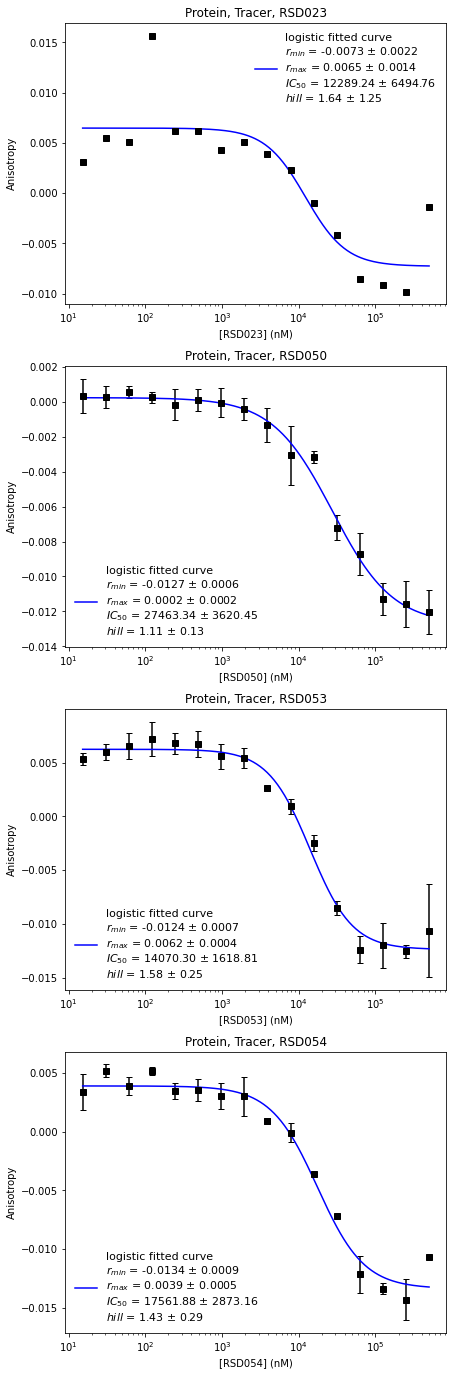

In [5]:
my_datac.plot_ani_com()

In [6]:
my_datac.import_params("C:\\Users\\Bartek\\Desktop\\final_fit_params.csv")

<ipython-input-2-73fda14baeac>:1613: UserWarning: The final_fit data frame does not contain following columns: '['LT', 'LT error']'
  warnings.warn(f"The final_fit data frame does not contain following columns: '{col_diff}'")


In [7]:
my_datac.final_fit

rmin  rmin error      rmax  rmax error  lambda  \
Protein Tracer RSD023 -0.011513    0.000356  0.124883    0.001465     1.0   
               RSD050 -0.011513    0.000356  0.124883    0.001465     1.0   
               RSD053 -0.011513    0.000356  0.124883    0.001465     1.0   
               RSD054 -0.011513    0.000356  0.124883    0.001465     1.0   

                                Kd    Kd error  
Protein Tracer RSD023  8782.305653  238.431649  
               RSD050  8782.305653  238.431649  
               RSD053  8782.305653  238.431649  
               RSD054  8782.305653  238.431649

In [8]:
my_datac.calc_amount_bound()

In [9]:
my_datac.single_site_com()

The Ki* is calculated based on the total protein concentration calculated from the measured anisotropy. Below each figure the values of total protein concentration from platemap (LT) and as calclualted from measured anisotropy (LT*) are stated.


C:\Program Files (x86)\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


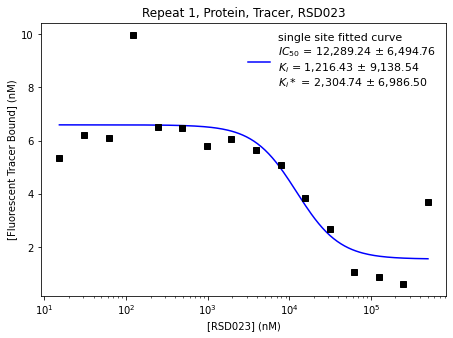

LT = 5000.0, LT* = 1341.336580217673


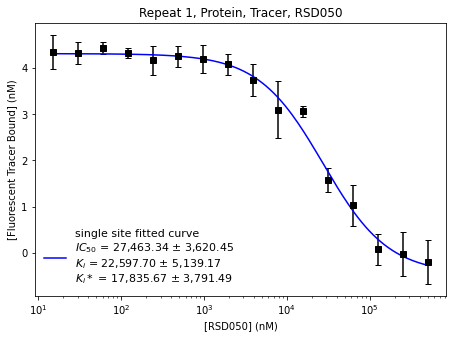

LT = 5000.0, LT* = 832.0853160269054


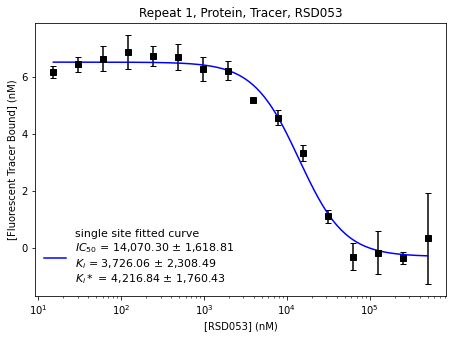

LT = 5000.0, LT* = 1319.7821366397964


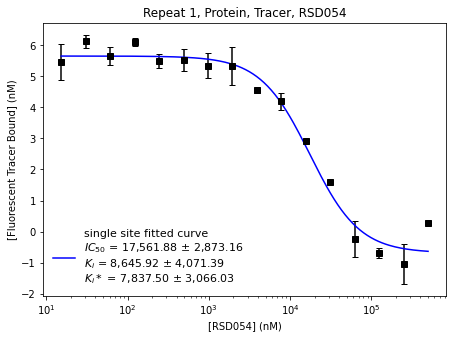

LT = 5000.0, LT* = 1125.4738803060816


In [10]:
my_datac.plot_ic50()

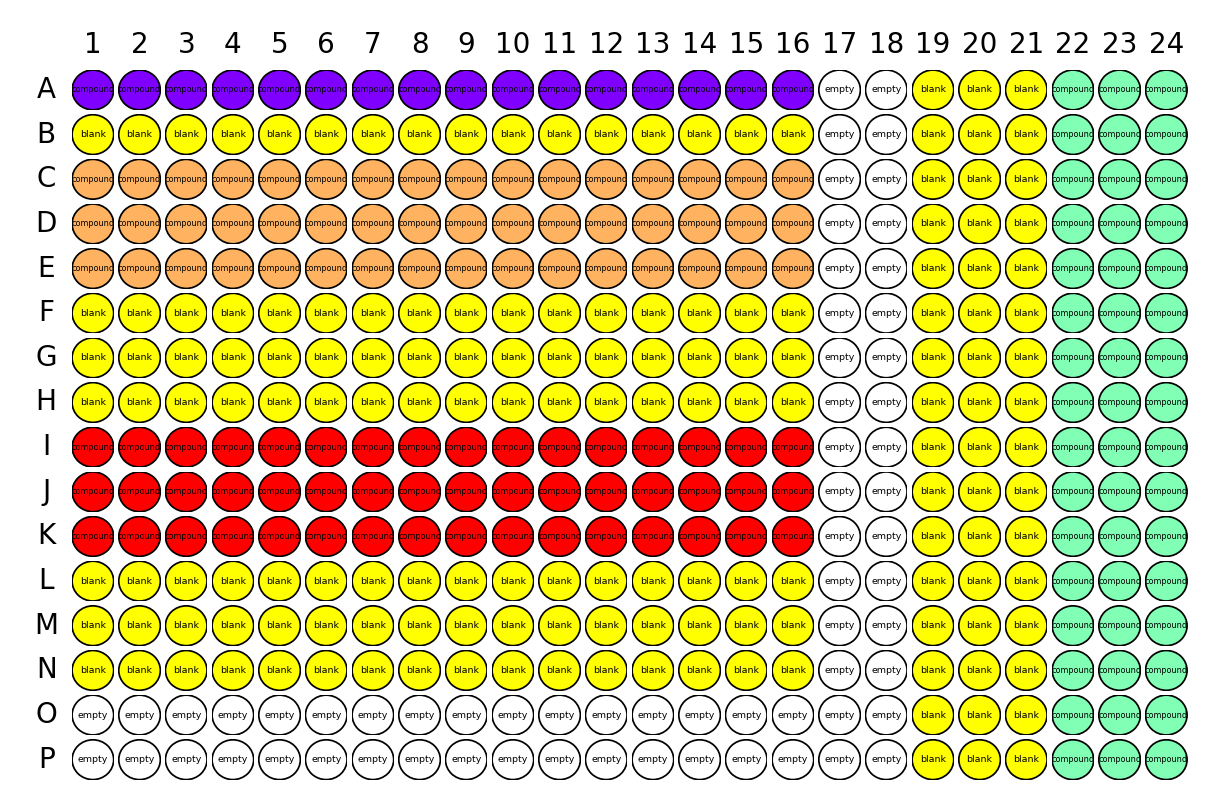

In [12]:
my_datac.visualise(colorby='Competitor Name', labelby='Type')

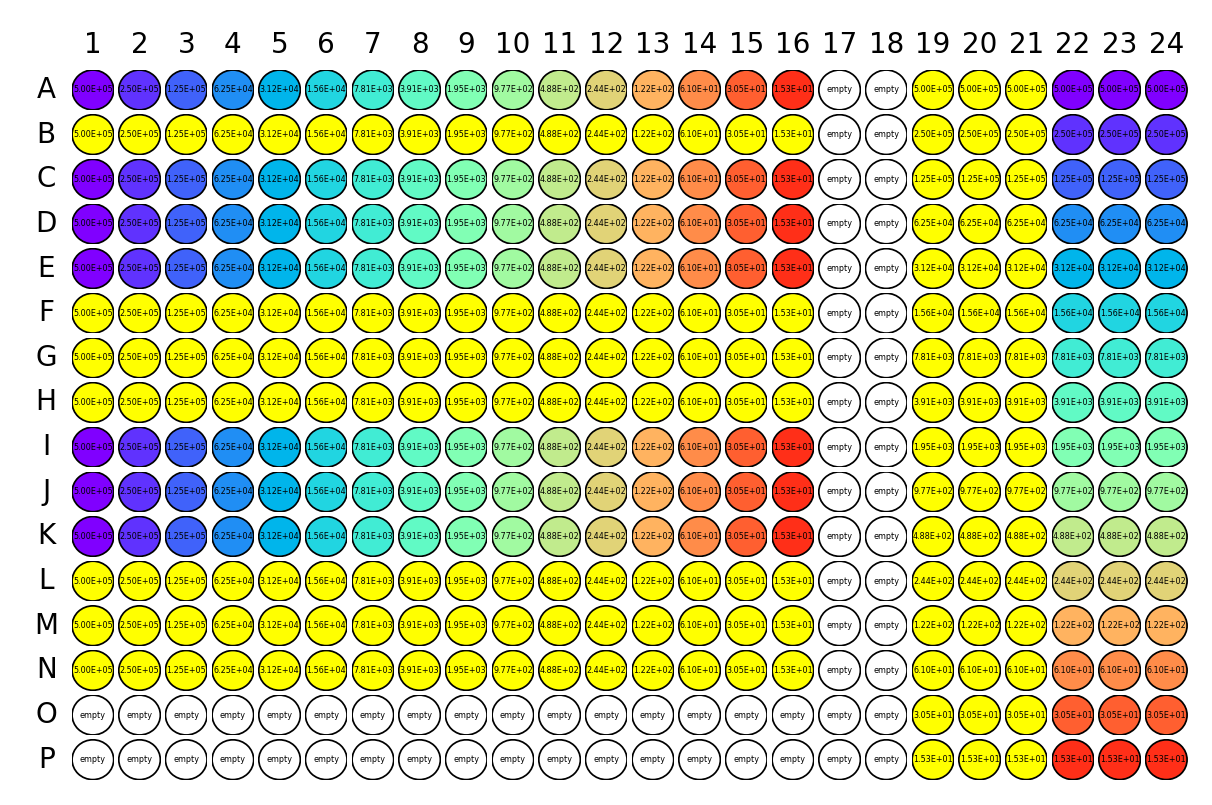

In [14]:
my_datac.visualise(labelby='Competitor Concentration', colorby='Competitor Concentration')

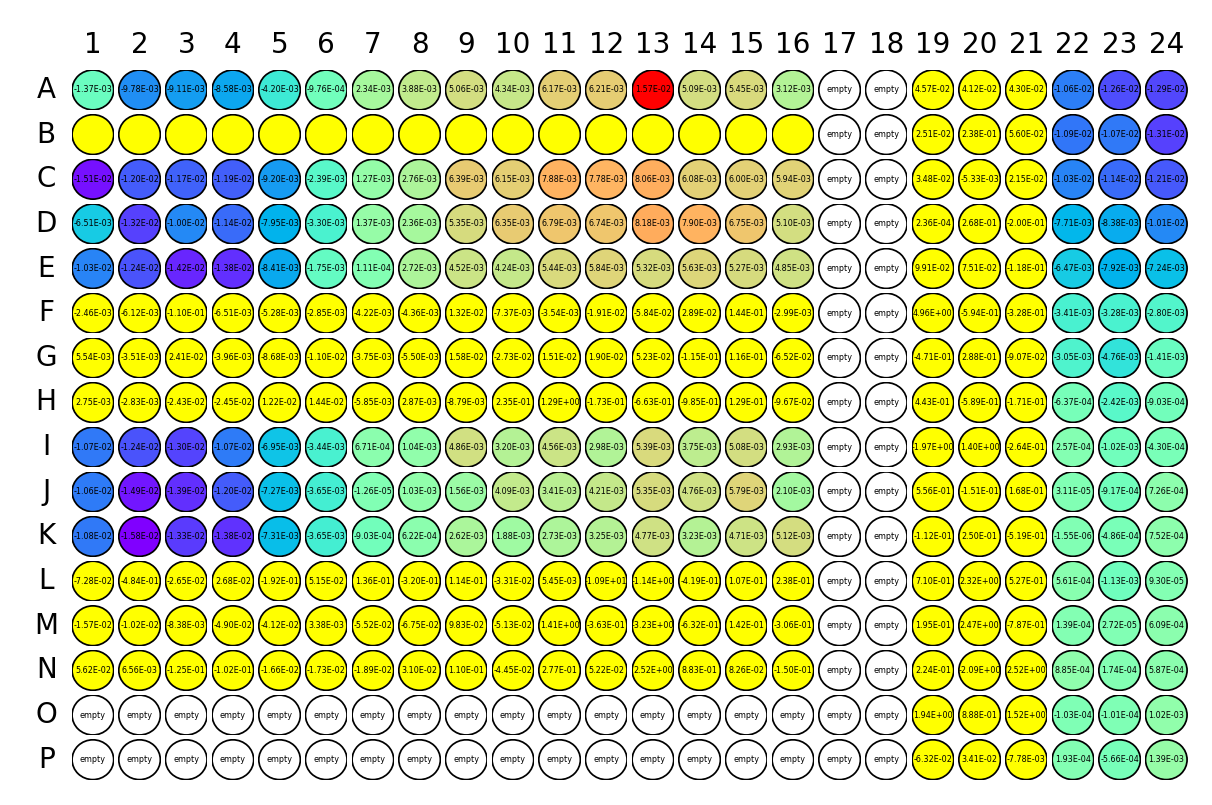

In [15]:
my_datac.visualise(colorby=('repeat_1', 'r_corrected'), labelby=('repeat_1', 'r_corrected'))

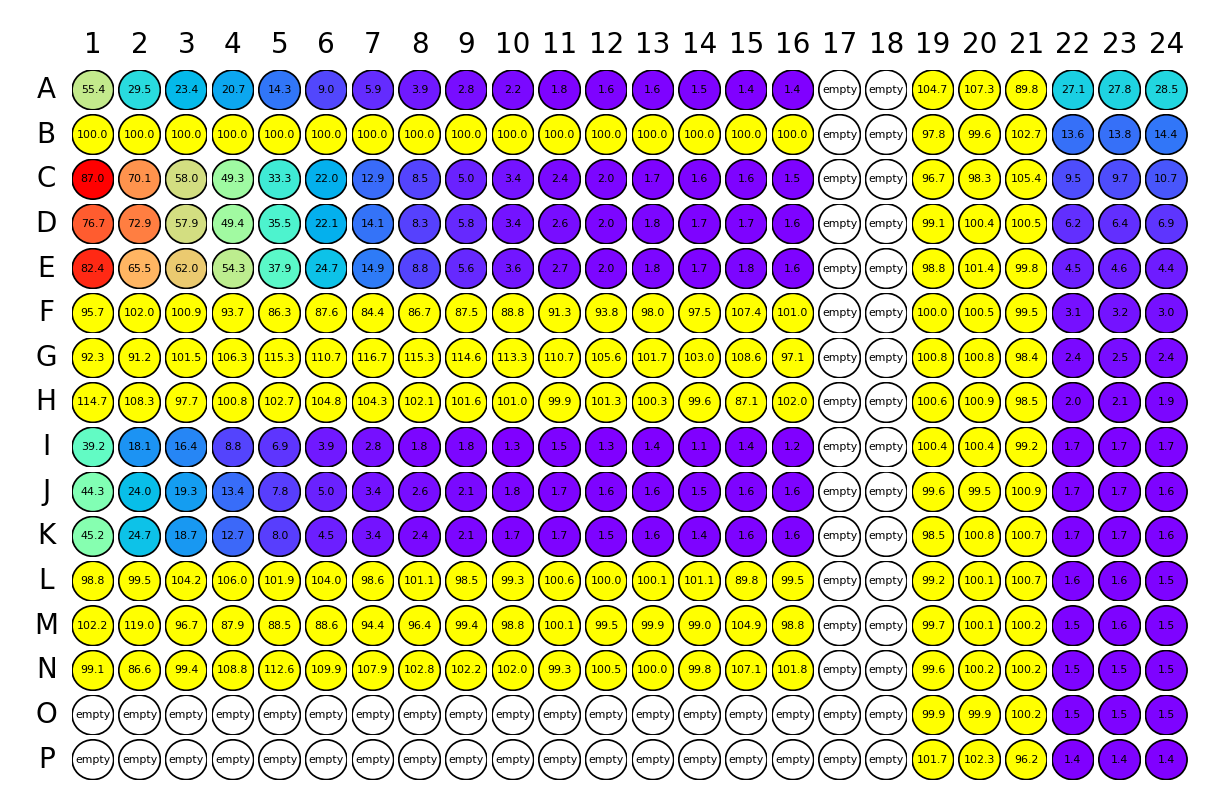

In [16]:
my_datac.visualise(labelby=('repeat_1', 'i_percent'), colorby=('repeat_1', 'i_percent'))

In [12]:
my_data = FA.read_in_envision(data_csv=AURKA_NMYC, platemap_csv=AURKA_NMYC_platemap, data_type='plate', size=384)
my_data.background_correct()
my_data.calc_r_i(plot_i=False)
my_data.calc_mean_r_i()
my_data.logistic_fit()
my_data.calc_lambda()

Data has been uploaded!

Number of repeats: 1 
Value of g-factor: 1.0 
Overall number of empty cells is 480 in 2 data frames.
Proteins: ['Protein']
Tracers: ['Tracer']
Competitors: ['-']
Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!

Choose the lambda values that will be saved for each protein-tracer pair. 
If you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.
If you do not choose any lambda value for a given protein-tracer pair the default value of 1 will remain but you still need to select the rmin and rmax for this pair.


Button(description='Save', style=ButtonStyle())

Selected values were saved.


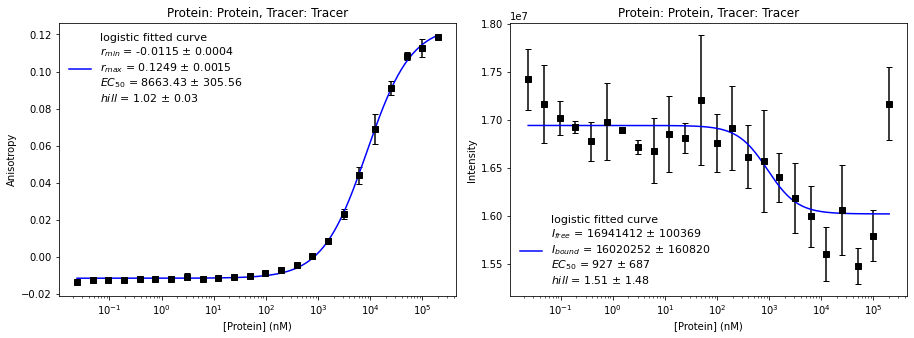

In [13]:
my_data.plot_ani()

In [14]:
my_data.calc_amount_bound()
my_data.single_site_fit()

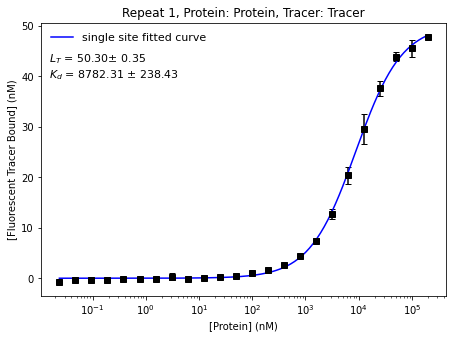

In [15]:
my_data.plot_kd()

In [16]:
my_data.final_fit

,,,rmin,rmin error,rmax,rmax error,lambda,Kd,Kd error,LT,LT error
Protein,Tracer,-,-0.0115128,0.000356125,0.124883,0.0014654,1,8782.31,238.432,50.299635,0.349404


In [17]:
my_data.export_params(path="C:\\Users\\Bartek\\Desktop\\")

The fitting parameters were exported to the csv files.


In [18]:
my_data1 = FA.read_in_envision(data_csv=HsHis6_PEX5C_vs_HsPEX5C, platemap_csv=Hs_His6_PEX5C_vs_HsPEX5C_platemap, data_type='plate', size=384)

Data has been uploaded!

Number of repeats: 1 
Value of g-factor: 1.0 
Overall number of empty cells is 192 in 2 data frames.
Proteins: ['Hs-His6-PEX5C' 'HsPEX5C']
Tracers: ['Lissamine-YQSKL']
Competitors: ['-']


In [19]:
my_data1.background_correct()
my_data1.calc_r_i(plot_i=False)
my_data1.calc_mean_r_i()
my_data1.logistic_fit()
my_data1.logistic_fit(prot=['Hs-His6-PEX5C'], trac=['Lissamine-YQSKL'], var='i', sigma='std', p0=[500000, 300000, 1300, 2])
my_data1.calc_lambda()

Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!

Choose the lambda values that will be saved for each protein-tracer pair. 
If you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.
If you do not choose any lambda value for a given protein-tracer pair the default value of 1 will remain but you still need to select the rmin and rmax for this pair.


<ipython-input-2-fc8df0b46894>:840: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))   # calculate the error of the fitting params


Button(description='Save', style=ButtonStyle())

Selected values were saved.


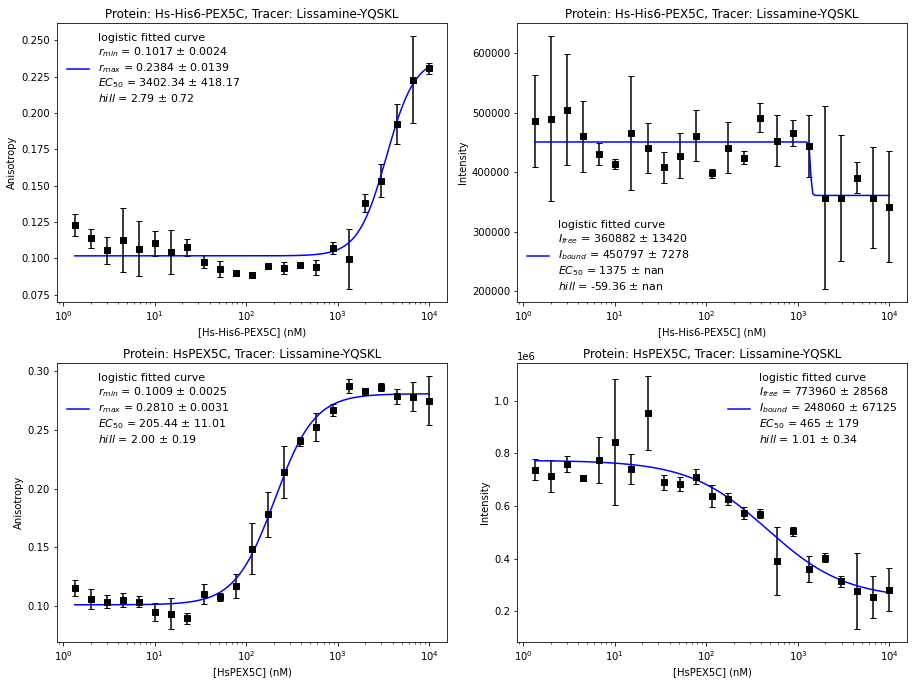

In [20]:
my_data1.plot_ani()

In [21]:
my_data1.calc_amount_bound()
my_data1.single_site_fit()
my_data1.single_site_fit(prot=['Hs-His6-PEX5C'], bounds=([0,0],[200, 20000]))

C:\Program Files (x86)\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


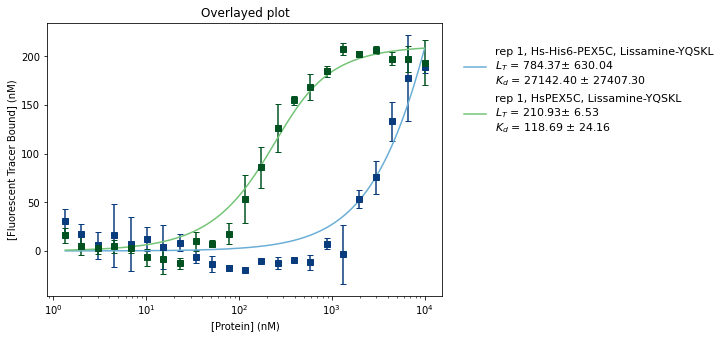

In [22]:
my_data1.plot_kd(overlay=True)#, legend=True, export="C:\\Users\\Bartek\\Desktop\\", dpi=500)

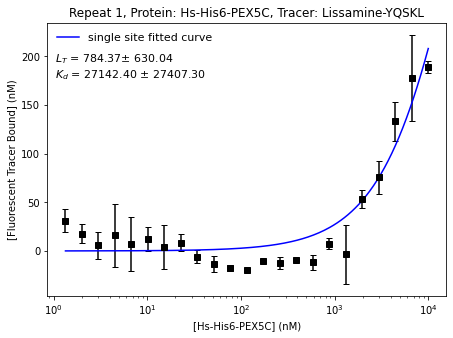

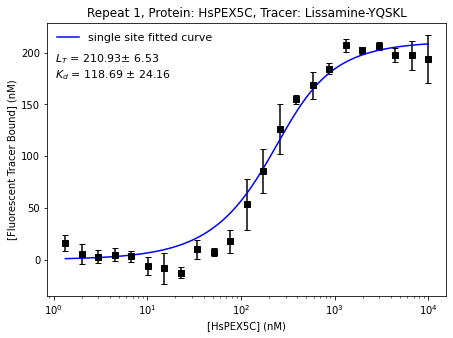

In [23]:
my_data1.plot_kd()# prot=['all'], trac=['all'], overlay=False, legend=True)

In [46]:
my_data2 = FA.read_in_envision(data_csv=HsPEX5C_Y467C_vs_AtPEX5C_WT, platemap_csv=HsPEX5C_Y467C_vs_AtPEX5C_WT_platemap, data_type='plate', size=384)
my_data2.background_correct()
my_data2.calc_r_i(plot_i = False)
my_data2.calc_mean_r_i()
my_data2.logistic_fit()

Data has been uploaded!

Number of repeats: 1 
Value of g-factor: 1.0 
Overall number of empty cells is 192 in 2 data frames.
Proteins: ['HsPEx5C Y467C' 'AtPEX5C WT']
Tracers: ['Lissamine-YQSKL']
Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



<ipython-input-24-ea3b195a74ca>:893: RuntimeWarning: The curve fitting failed in the following cases:

[('repeat_1', 'i', ('AtPEX5C WT', 'Lissamine-YQSKL'), RuntimeError('Optimal parameters not found: Number of calls to function has reached maxfev = 1000.'))]

Try passing additional keyword arguments to the fitting function.
  warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nTry passing additional keyword arguments to the fitting function.", RuntimeWarning)


In [47]:
my_data2.logistic_fit(prot=['AtPEX5C WT'], rep=[1], sigma='std')

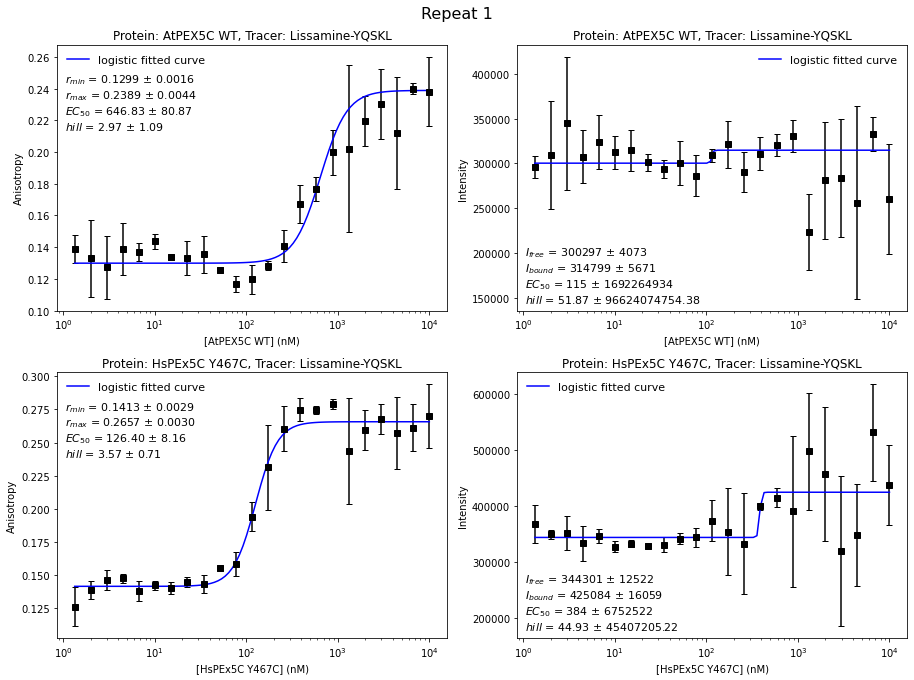

In [48]:
my_data2.plot_ani(err='std')

In [49]:
my_data2.calc_lambda()

Choose the lambda values that will be saved for each protein-tracer pair. 
If you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.
If you do not choose any lambda value for a given protein-tracer pair the default value of 1 will remain but you still need to select the rmin and rmax for this pair.


Button(description='Save', style=ButtonStyle())

Selected values were saved.


C:\Program Files (x86)\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


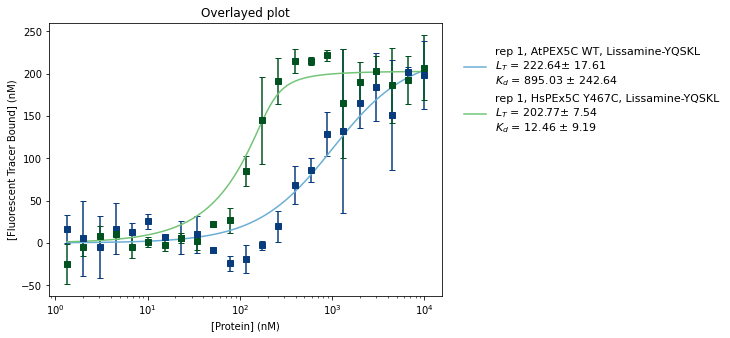

In [50]:
my_data2.calc_amount_bound()
my_data2.single_site_fit()
my_data2.plot_kd(overlay=True)

In [51]:
my_data3 = FA.read_in_envision(data_csv=F606C_vs_AtPEX5C_WT_1_hour, platemap_csv=F606C_vs_AtPEX5C_WT_1_hour_platemap, data_type='plate', size=384)
my_data3.background_correct()
my_data3.calc_r_i(plot_i = False)
my_data3.calc_mean_r_i()
my_data3.logistic_fit()

Data has been uploaded!

Number of repeats: 1 
Value of g-factor: 1.0 
Overall number of empty cells is 192 in 2 data frames.
Proteins: ['AtPEX5C F606C' 'AtPEX5C WT']
Tracers: ['Lissamine-YQSKL']
Background correction has been successfully performed!
The fluorescence intensity and anisotropy have been successfully calculated!



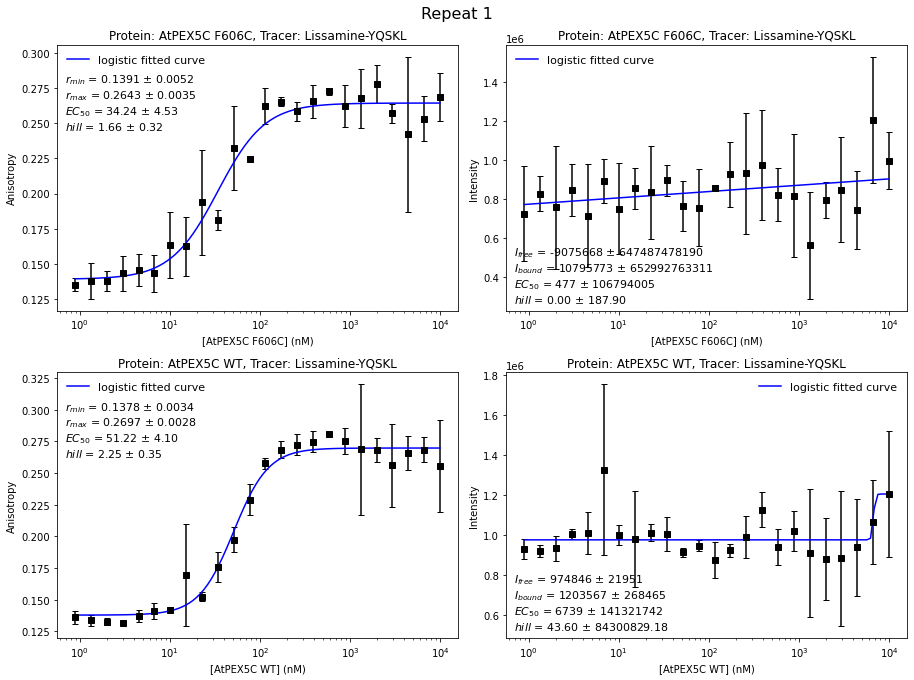

In [52]:
my_data3.plot_ani()

In [53]:
my_data3.calc_lambda()

Choose the lambda values that will be saved for each protein-tracer pair. 
If you choose more than one lambda value for a given protein-tracer pair, only the first choice will be saved.
If you do not choose any lambda value for a given protein-tracer pair the default value of 1 will remain but you still need to select the rmin and rmax for this pair.


Button(description='Save', style=ButtonStyle())

Selected values were saved.


In [54]:
my_data3.calc_amount_bound()
my_data3.single_site_fit()

C:\Program Files (x86)\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Program Files (x86)\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-24-ea3b195a74ca>:946: RuntimeWarning: The curve fitting failed in the following cases:

[('repeat_1', ('AtPEX5C WT', 'Lissamine-YQSKL'), RuntimeError('Optimal parameters not found: Number of calls to function has reached maxfev = 600.'))]

Try passing additional keyword arguments to the fitting function
  warnings.warn(f"The curve fitting failed in the following cases:\n\n{errors}\n\nTry passing additional keyword arguments to the fitting function", RuntimeWarning)


In [55]:
my_data3.single_site_fit(rep=[1], prot=['AtPEX5C WT'], sigma='std')

C:\Program Files (x86)\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<ipython-input-24-ea3b195a74ca>:904: RuntimeWarning: invalid value encountered in sqrt
  return ( (LT+PT+Kd) - np.sqrt( ( ((LT+PT+Kd)**2) - (4*LT*PT) ) ) ) / 2


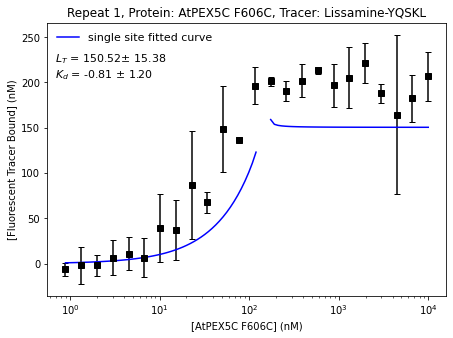

<ipython-input-24-ea3b195a74ca>:904: RuntimeWarning: invalid value encountered in sqrt
  return ( (LT+PT+Kd) - np.sqrt( ( ((LT+PT+Kd)**2) - (4*LT*PT) ) ) ) / 2


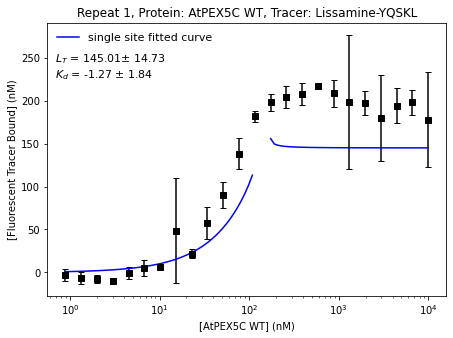

In [56]:
my_data3.plot_kd()